# Exploration, Grouping, and Prediction of Genre in Spotify Songs
## Team Spotiflies: Joanna, Aaron, Aubrey, Kennedy, Aster, Ethan
GitHub Link: https://github.com/ketexon/csm148-spotiflies


The data set that we chose for the project was the Spotify dataset, which is a dataset with information about the popularity, genre, and several other musical qualities of over 140K songs on the Spotify music streaming platform. The link to the original dataset can be found here: https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset.

The main feature we're interested in with this dataset is song genre, and how it relates to other features. We want to see if the musical qualities of a song are strong influences of what genre it's categorized. The dataset has 114 different genres, ranging from emo to classical to industrial and more. We are interested in answering questions regarding what, if anything, in songs may be a predictor of what genre it is, if certain genres are more similar to each other than others, and more. 

## First Looks and Cleaning Our Data
We started our project by investigating our data for any obvious cleaning we have to do before EDA, such as missing data or unreasonable values. 

In [50]:
%pip install pandas numpy matplotlib seaborn scikit-learn mlxtend


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, permutation_test_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, auc,
    classification_report, accuracy_score, confusion_matrix,
    adjusted_rand_score, silhouette_score
)
from sklearn.mixture import GaussianMixture
from mlxtend.evaluate import bias_variance_decomp

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl
import lightning.pytorch.callbacks as pl_callbacks
from torch.utils.data import DataLoader, Dataset, TensorDataset
from typing import cast

import os
is_linux = os.name == 'posix'

In [52]:
# Reading in the data
spotify = pd.read_csv("dataset.csv")
spotify

Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                        Ghost (Acoustic)   
2                                          To Begin Again   
3       Crazy Rich Asians (Original Motion Picture Sou...   
4                                                 Hold On   
...                                                   ...   
113995  #mindfulness - Soft Rain for Mindful Meditatio...   
113996  #mindfulness - Soft Rain for Mindful Meditatio...   
113997                                            Best Of   
113998                                  Change Your World   
113999                                     Miss Perfumado   

                        track_name  popularity  duration_ms  explicit  \
0                           Comedy          73       230666     False   
1                 Ghost - Acoustic          55       149610     False   
2                   To Begin Again          57       210826     False   
3       Can't Help Falling In Love          71       201933     False   
4                          Hold On          82       198853     False   
...                            ...         ...          ...       ...   
113995         Sleep My Little Boy          21       384999     False   
113996            Water Into Light          22       385000     False   
113997              Miss Perfumado          22       271466     False   
113998                     Friends          41       283893     False   
113999                   Barbincor          22       241826     False   

        danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0              0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1              0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2              0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3              0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4              0.618  0.4430  ...    -9.681     1       0.0526        0.4690   
...              ...     ...  ...       ...   ...          ...           ...   
113995         0.172  0.2350  ...   -16.393     1       0.0422        0.6400   
113996         0.174  0.1170  ...   -18.318     0       0.0401        0.9940   
113997         0.629  0.3290  ...   -10.895     0       0.0420        0.8670   
113998         0.587  0.5060  ...   -10.889     1       0.0297        0.3810   
113999         0.526  0.4870  ...   -10.204     0       0.0725        0.6810   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.000001    0.3580   0.7150   87.917               4   
1               0.000006    0.1010   0.2670   77.489               4   
2               0.000000    0.1170   0.1200   76.332               4   
3               0.000071    0.1320   0.1430  181.740               3   
4               0.000000    0.0829   0.1670  119.949               4   
...                  ...       ...      ...      ...             ...   
113995          0.928000    0.0863   0.0339  125.995               5   
113996          0.97

We decided to remove the "Unnamed: 0" column, since we can uniquely identify songs from their track_id, so the counter values aren't very useful.

In [53]:
spotify_clean = spotify.drop(columns=["Unnamed: 0"])

Then we looked into NA values, and found one observation. We decided to drop this row since along with missing values, it also has other unexpected/unreasonable statistics, such as popularity being 0, and a duration of 0.

In [54]:
print(spotify_clean.isna().sum())

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [55]:
# Looking specifically at the row of missing values
spotify_clean[spotify_clean.isna().any(axis=1)]

track_id artists album_name track_name  popularity  \
65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN           0   

       duration_ms  explicit  danceability  energy  key  loudness  mode  \
65900            0     False         0.501   0.583    7     -9.46     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
65900       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature track_genre  
65900  138.391               4       k-pop

In [56]:
# Dropping the row
spotify_clean = spotify_clean.dropna()

To investigate any unreasonable/odd values, we decided to visualize each numeric variable with boxplots.

In [57]:
# String and categorical columns in the dataset
# these will be dropped or one-hot-encoded depending on the model
string_columns = ['track_id', 'artists', 'album_name', 'track_name']
categorical_columns = ['key', 'mode', 'time_signature', 'track_genre']

# helper function to remove all categorical and string columns
def numeric(df: pd.DataFrame) -> pd.DataFrame:
    df_number = df.select_dtypes(include=[np.number])
    return df_number.loc[:,~df_number.columns.isin(categorical_columns)]

speechiness            Axes(0.125,0.11;0.110714x0.77)
acousticness        Axes(0.257857,0.11;0.110714x0.77)
instrumentalness    Axes(0.390714,0.11;0.110714x0.77)
liveness            Axes(0.523571,0.11;0.110714x0.77)
valence             Axes(0.656429,0.11;0.110714x0.77)
tempo               Axes(0.789286,0.11;0.110714x0.77)
dtype: object

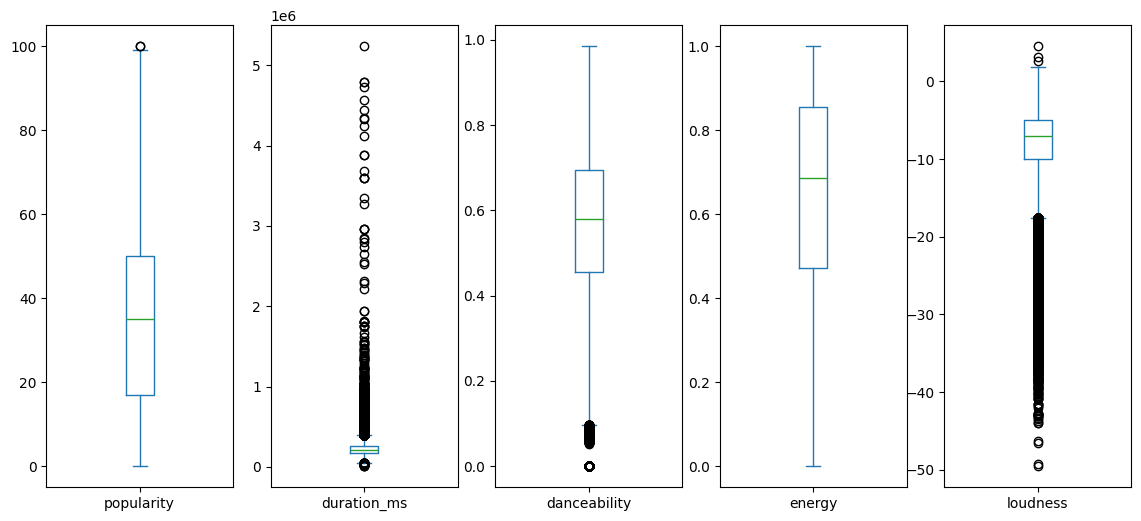

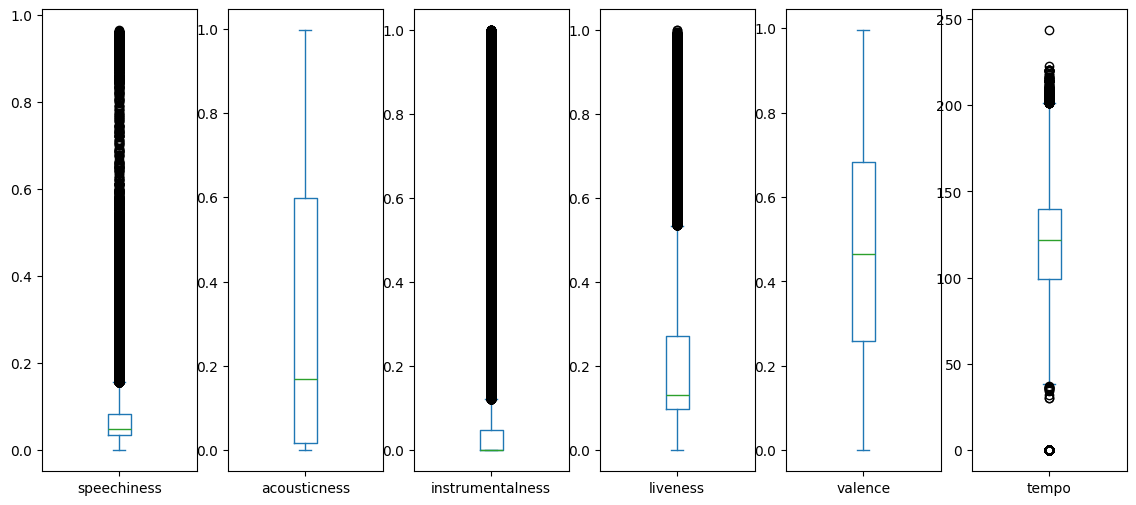

In [58]:
# Creating boxplots
numeric_spotify = numeric(spotify_clean)
columns = numeric_spotify.columns

numeric_spotify[columns[:len(columns) // 2]].plot.box(figsize = (14, 6), subplots=True)
numeric_spotify[columns[len(columns) // 2:]].plot.box(figsize = (14, 6), subplots=True)

Based on the boxplots, there seem to be quite a few numeric variables with a significant number of outliers. However, we decided to mainly only focus on the songs in which these outliers would be unreasonable based on domain knowledge, including duration being too low, the tempo being too slow, and the time signature being 0. 

First, we addressed the songs with duration being too low (the song is too short). We decided that a threshold for a song to be "too short" as a song that is shorter than 30 seconds.

In [59]:
short_songs = spotify_clean[spotify_clean['duration_ms'] < 30000]

print(f"Number of tracks with duration less than 30 seconds: {len(short_songs)}")
short_songs

Number of tracks with duration less than 30 seconds: 16


track_id  \
11398   1egJZfc8JBT2blFQ4clPKe   
16288   1T5QvLF9lO4HO3OZQbaX9p   
16292   5viwzFJxwRE1OEUR7G6hiD   
16856   5YKCM3jbJ8lqUXUwfU7KwZ   
39233   1T5QvLF9lO4HO3OZQbaX9p   
39236   5viwzFJxwRE1OEUR7G6hiD   
59306   3qSaeaXmtOuzkqe7DKgoiM   
59310   6hsyfegVY5yklJneM40mWi   
59434   1AsX7B48DFJZplJEwmhGpl   
59458   1sayezH8bWoxHMAQCccCTi   
59609   1oVrTBrCsM2eTE1G50yxY9   
59711   787rIUDmWWBIfZXwHUeXXQ   
59775   1HVjSh7scH1PaPiLjy2LEu   
59812   38Ogh3rsHba83kXx13gbKs   
66925   0DVMaexfdXDz19zUv1zKej   
101159  6bg9fEHIulR3DYNYbWG0Jz   

                                                  artists  \
11398                    Benjamin Britten;Steven Isserlis   
16288                    Robert Schumann;Pavel Nersessian   
16292                    Robert Schumann;Pavel Nersessian   
16856              Wolfgang Amadeus Mozart;Ingrid Haebler   
39233                    Robert Schumann;Pavel Nersessian   
39236                    Robert Schumann;Pavel Nersessian   
59306                                          Leila Bela   
59310                                          Leila Bela   
59434   Alireza Mashayekhi;Ata Ebtekar;The Iranian Orc...   
59458                                          Leila Bela   
59609                                          Leila Bela   
59711                                          Leila Bela   
59775                      Leila Bela;Leila's Opera Class   
59812                                          Leila Bela   
66925                                   Dora The Explorer   
101159  Traditional;Cappella Musicale di Santa Maria i...   

                                               album_name  \
11398                          October Classical Playlist   
16288   Schumann, Poulenc & Others: Piano Works (Live ...   
16292   Schumann, Poulenc & Others: Piano Works (Live ...   
16856                  Mozart: The Complete Piano Sonatas   
39233   Schumann, Poulenc & Others: Piano Works (Live ...   
39236   Schumann, Poulenc & Others: Piano Works (Live ...   
59306                                         Angra Manyu   
59310                                         Angra Manyu   
59434                                       Ornamentalism   
59458                                         Angra Manyu   
59609                                         Angra Manyu   
59711                                         Angra Manyu   
59775                                         Angra Manyu   
59812                                         Angra Manyu   
66925                                   Dora The Explorer   
101159       Giovannini: Messa a Quattro Breve Concertata   

                                               track_name  popularity  \
11398   Cello Suite No. 3, Op. 87: IX. Passacaglia (Ex...           0   
16288   Carnaval, Op. 9: No. 20, Pause (Live in Japan,...           0   
16292   Carnaval, Op. 9: No. 13, Estrella (Live in Jap...           0   
16856                           Andante in C Major, K. 1a           0   
39233   Carnaval, Op. 9: No. 20, Pause (Live in Japan,...           0   
39236   Carnaval, Op. 9: No. 13, Estrella (Live in Jap...           0   
59306                                                 V-7           0   
59310                              The Exorsism Begins...           0   
59434                                          Aural Blue           0   
59458                                                 V-3           0   
59609                                             Shatter           0   
59711                                       Breath Ritual           0   
59775   Screams for a Finale! (feat. Leila's Opera Class)           0   
59812                                                 V-4           0   
66925                                 Backpack, Backpack!           8   
101159                                         Pax Domini           0   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
11398         22266     False         0.335  0.05

We found that there are only 16 songs that are less than 30 seconds. Since there were so few, we decided to look manually into these songs and investigate whether or not these songs seem to be real songs. Turns out, the majority of them are concert pauses (empty tracks) or sound effects and sound clips. Since we don't want these tracks to affect our investigation of genres, we decided to drop them. 

In [60]:
spotify_clean = spotify_clean[spotify_clean['duration_ms'] >= 30000]

Next we looked at implausible 0 values with time signature and tempo. For context, time signature should be expressed in a fraction, while tempo is in BPM (so 0 BPM doesn't make sense). 

In [61]:
print("Tempos == 0: ", spotify_clean["tempo"].eq(0).sum())
print("Time signatures == 0: ", spotify_clean["time_signature"].eq(0).sum())

Tempos == 0:  155
Time signatures == 0:  161


In [62]:
tempo_timesig_0_songs = spotify_clean[(spotify_clean['tempo'] == 0) | (spotify_clean['time_signature'] == 0)]
tempo_timesig_0_songs

track_id  \
2926    0jdfbvSdaWvxfAlD20TtNc   
4131    59gg6zQhSKGVnkT3hWAY3l   
4379    4acmzQsAeMJa5sGFSog7fu   
4664    1Kb2DqjHRvOcT5xeWtz3t5   
26910   7HSc2wpHlXKIl8SCZK7zsP   
...                        ...   
101993  6H0kAiSAFB84jX7dgEDWd6   
112172  0jdfbvSdaWvxfAlD20TtNc   
113428  5EYzrykQ95uOmepteDi9KT   
113688  2EnZf7wbFv7ST4CJ3EvNzT   
113856  6XsYJ0dwT2hRzp0Qles78F   

                                                  artists  \
2926                                           Yaşlı Amca   
4131                                Max Richter;Lang Lang   
4379     Dario Marianelli;Jack Liebeck;Benjamin Wallfisch   
4664                                     Sylvain Chauveau   
26910                                        Benny Martin   
...                                                   ...   
101993                                        Rain Sounds   
112172                                         Yaşlı Amca   
113428  El Ruido Blanco;Soñoliento Juan;Mantra para Do...   
113688                                    El Ruido Blanco   
113856                                  Колыбельная-земля   

                                               album_name  \
2926                                            Akşamüstü   
4131                      Voyager - Essential Max Richter   
4379       Jane Eyre - Original Motion Picture Soundtrack   
4664                              Des Plumes Dans La Tête   
26910             Here Comes the Sun (Piano Instrumental)   
...                                                   ...   
101993                                               Rain   
112172                                          Akşamüstü   
113428                 Aire Acondicionado de Ruido Blanco   
113688  Ruido Blanco para el bebé: sonidos relajantes ...   
113856  Расслабляющие звуки - белый шум для вашего реб...   

                                       track_name  popularity  duration_ms  \
2926                              Sanki Yapamadım          44       213198   
4131                                The Departure          64       151506   
4379    The End of Childhood (feat. Jack Liebeck)          55        73266   
4664                               Ferme Les Yeux          53        68493   
26910     Here Comes the Sun (Piano Instrumental)          18       203705   
...                                           ...         ...          ...   
101993                    Rain: Natural Recording          32        84219   
112172                            Sanki Yapamadım          44       213198   
113428                             Aire de verano          27       128000   
113688         Ruido Rosa Puro - Una Hora Versión          24      3601693   
113856                        Пылесос (Белый шум)          22       302185   

        explicit  danceability   energy  key  loudness  mode  speechiness  \
2926       False         0.442  0.56700    8    -6.346     0       0.0516   
4131       False         0.000  0.03620    0   -22.519     0       0.0000   
4379       False         0.000  0.04450    0   -26.440     0       0.0000   
4664       False         0.000  0.03230    2   -23.636     0       0.0000   
26910      False         0.329  0.06070    9   -28.310     1       0.0507   
...          ...           ...      ...  ...       ...   ...          ...   
101993     False         0.000  0.02540    8   -19.925     1       0.0000   
112172     False         0.442  0.56700    8    -6.346     0       0.0516   
113428     False         0.000  0.18800    8   -25.837     0       0.0000   
113688     False         0.000  0.00002    1   -11.165     1       0.0000   
113856     False         0.000  0.22400    8   -10.224     1       0.0000   

        acousticness  instrumentalness  liveness  valence    tempo  \
2926        0.238000          0.000325    0.0852    0.639  138.616   
4131        0.994000          0.940000    0.0958    0.000    0.000   
4379        0.972000          0.972000    0.0873    0.000    0.000   
4664 

We manually looked through the songs with time signature and tempos of 0, and found that most of them tended to be ambient tracks, such as tracks of rainfall sounds or white noise. We decided that it might be good to remove these rows from our cleaned dataset, as we didn't want to the zero values to skew the rest of our exploration in any way, and also because we hoped to look more a typical songs rather than ambient tracks. 

Additionally, the overall count of these suspicious rows wasn't very high compared to size of the entire dataset (163 vs > 114k), so we figured that removing these values wouldn't drastically affect the size and comprehensiveness of our dataset.

We also confirmed this decision by seeing how the means of some of the other variables would change based on if we removed or kept these suspicious rows (see below).

In [63]:
spotify_clean_temp = spotify_clean[spotify_clean['time_signature']!= 0]
spotify_clean_temp = spotify_clean[spotify_clean['tempo']!= 0]

mean_temp = spotify_clean_temp.mean(numeric_only=True)
mean_clean = spotify_clean.mean(numeric_only=True)

# Calculate the difference
mean_difference = mean_clean - mean_temp
mean_difference

popularity           0.006038
duration_ms        -73.741857
explicit            -0.000116
danceability        -0.000772
energy              -0.000706
key                 -0.000157
loudness            -0.018772
mode                 0.000072
speechiness         -0.000115
acousticness         0.000240
instrumentalness     0.000676
liveness             0.000327
valence             -0.000646
tempo               -0.166333
time_signature      -0.005316
dtype: float64

From this, the effects on the means by removing the suspicious rows doesn't seem to be too large, with the largest being duration, which is measured in milliseconds, so would actually be less than a second difference. Thus, we dropped the rows where time signature or tempo were 0, which was a total of 161 rows.

In [64]:
spotify_clean = spotify_clean_temp
spotify_clean

track_id                 artists  \
0       5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1       4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2       1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3       6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4       5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...                        ...                     ...   
113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                        Ghost (Acoustic)   
2                                          To Begin Again   
3       Crazy Rich Asians (Original Motion Picture Sou...   
4                                                 Hold On   
...                                                   ...   
113995  #mindfulness - Soft Rain for Mindful Meditatio...   
113996  #mindfulness - Soft Rain for Mindful Meditatio...   
113997                                            Best Of   
113998                                  Change Your World   
113999                                     Miss Perfumado   

                        track_name  popularity  duration_ms  explicit  \
0                           Comedy          73       230666     False   
1                 Ghost - Acoustic          55       149610     False   
2                   To Begin Again          57       210826     False   
3       Can't Help Falling In Love          71       201933     False   
4                          Hold On          82       198853     False   
...                            ...         ...          ...       ...   
113995         Sleep My Little Boy          21       384999     False   
113996            Water Into Light          22       385000     False   
113997              Miss Perfumado          22       271466     False   
113998                     Friends          41       283893     False   
113999                   Barbincor          22       241826     False   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
0              0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1              0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2              0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3              0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4              0.618  0.4430    2    -9.681     1       0.0526        0.4690   
...              ...     ...  ...       ...   ...          ...           ...   
113995         0.172  0.2350    5   -16.393     1       0.0422        0.6400   
113996         0.174  0.1170    0   -18.318     0       0.0401        0.9940   
113997         0.629  0.3290    0   -10.895     0       0.0420        0.8670   
113998         0.587  0.5060    7   -10.889     1       0.0297        0.3810   
113999         0.526  0.4870    1   -10.204     0       0.0725        0.6810   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.000001    0.3580   0.7150   87.917               4   
1               0.000006    0.1010   0.2670   77.489               4   
2               0.000000    0.1170   0.1200   76.332               4   
3               0.000071    0.1320   0.1430  181.740               3   
4               0.000000    0.0829   0.1670  119.949               4   
...                  ...       ...      ...      ...             ...   
113995          0.928000    0.0863   0.0339  125.995               5   
113996          0.976000    0.1050   0.0350   85.239               4   
113997          0.000000    0.0839   0.7430  132.378               4   
113998          0.000000    0.2700

Since there don't seem to be anymore values in our dataset that are unreasonable or missing, we exported our cleaned dataset to start exploring and visualizing our data.

In [65]:
# Exporting our cleaned dataset for analysis
spotify_clean.to_csv('spotify.csv', index=False)

## Exploratory Data Analysis (EDA)

In order to find out a little more about the general structure and features of our dataset, we did some exploratory data analysis. We started by looking at the shape and structure of the data, and then the correlations between the numeric values, and then also did some visualizations of categorical features. 

In [66]:
# Read in the cleaned data
spotify = pd.read_csv('spotify.csv')
spotify

track_id                 artists  \
0       5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1       4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2       1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3       6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4       5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...                        ...                     ...   
113823  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113824  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113825  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113826  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113827  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                        Ghost (Acoustic)   
2                                          To Begin Again   
3       Crazy Rich Asians (Original Motion Picture Sou...   
4                                                 Hold On   
...                                                   ...   
113823  #mindfulness - Soft Rain for Mindful Meditatio...   
113824  #mindfulness - Soft Rain for Mindful Meditatio...   
113825                                            Best Of   
113826                                  Change Your World   
113827                                     Miss Perfumado   

                        track_name  popularity  duration_ms  explicit  \
0                           Comedy          73       230666     False   
1                 Ghost - Acoustic          55       149610     False   
2                   To Begin Again          57       210826     False   
3       Can't Help Falling In Love          71       201933     False   
4                          Hold On          82       198853     False   
...                            ...         ...          ...       ...   
113823         Sleep My Little Boy          21       384999     False   
113824            Water Into Light          22       385000     False   
113825              Miss Perfumado          22       271466     False   
113826                     Friends          41       283893     False   
113827                   Barbincor          22       241826     False   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
0              0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1              0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2              0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3              0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4              0.618  0.4430    2    -9.681     1       0.0526        0.4690   
...              ...     ...  ...       ...   ...          ...           ...   
113823         0.172  0.2350    5   -16.393     1       0.0422        0.6400   
113824         0.174  0.1170    0   -18.318     0       0.0401        0.9940   
113825         0.629  0.3290    0   -10.895     0       0.0420        0.8670   
113826         0.587  0.5060    7   -10.889     1       0.0297        0.3810   
113827         0.526  0.4870    1   -10.204     0       0.0725        0.6810   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.000001    0.3580   0.7150   87.917               4   
1               0.000006    0.1010   0.2670   77.489               4   
2               0.000000    0.1170   0.1200   76.332               4   
3               0.000071    0.1320   0.1430  181.740               3   
4               0.000000    0.0829   0.1670  119.949               4   
...                  ...       ...      ...      ...             ...   
113823          0.928000    0.0863   0.0339  125.995               5   
113824          0.976000    0.1050   0.0350   85.239               4   
113825          0.000000    0.0839   0.7430  132.378               4   
113826          0.000000    0.2700

In [67]:
spotify.describe()

popularity   duration_ms   danceability         energy  \
count  113828.000000  1.138280e+05  113828.000000  113828.000000   
mean       33.237384  2.281340e+05       0.567603       0.642140   
std        22.314498  1.062882e+05       0.172371       0.250761   
min         0.000000  3.008000e+04       0.051300       0.000020   
25%        17.000000  1.742130e+05       0.456000       0.473000   
50%        35.000000  2.130000e+05       0.580000       0.685000   
75%        50.000000  2.615970e+05       0.695000       0.854000   
max       100.000000  5.237295e+06       0.985000       1.000000   

                 key       loudness           mode    speechiness  \
count  113828.000000  113828.000000  113828.000000  113828.000000   
mean        5.309186      -8.238433       0.637488       0.084758   
std         3.559470       4.991371       0.480728       0.105735   
min         0.000000     -46.591000       0.000000       0.022100   
25%         2.000000     -10.000250       0.000000       0.035900   
50%         5.000000      -6.997000       1.000000       0.049000   
75%         8.000000      -5.000000       1.000000       0.084600   
max        11.000000       4.532000       1.000000       0.965000   

        acousticness  instrumentalness       liveness        valence  \
count  113828.000000     113828.000000  113828.000000  113828.000000   
mean        0.314602          0.155314       0.213220       0.474737   
std         0.332302          0.308835       0.189925       0.258831   
min         0.000000          0.000000       0.009250       0.000000   
25%         0.016900          0.000000       0.098000       0.261000   
50%         0.168000          0.000041       0.132000       0.464000   
75%         0.597000          0.047600       0.273000       0.683000   
max         0.996000          1.000000       1.000000       0.995000   

               tempo  time_signature  
count  113828.000000   113828.000000  
mean      122.317259        3.909460  
std        29.653245        0.407685  
min        30.200000        0.000000  
25%        99.432750        4.000000  
50%       122.024000        4.000000  
75%       140.078000        4.000000  
max       243.372000        5.000000

In [68]:
# Select only numeric columns (remove categorical ones) using numeric() function written in data cleaning section
# Removed categorical columns: key, time signature, mode
numeric_spotify = numeric(spotify)

We started by looking at the distributions of all of the numeric variables with a histogram.

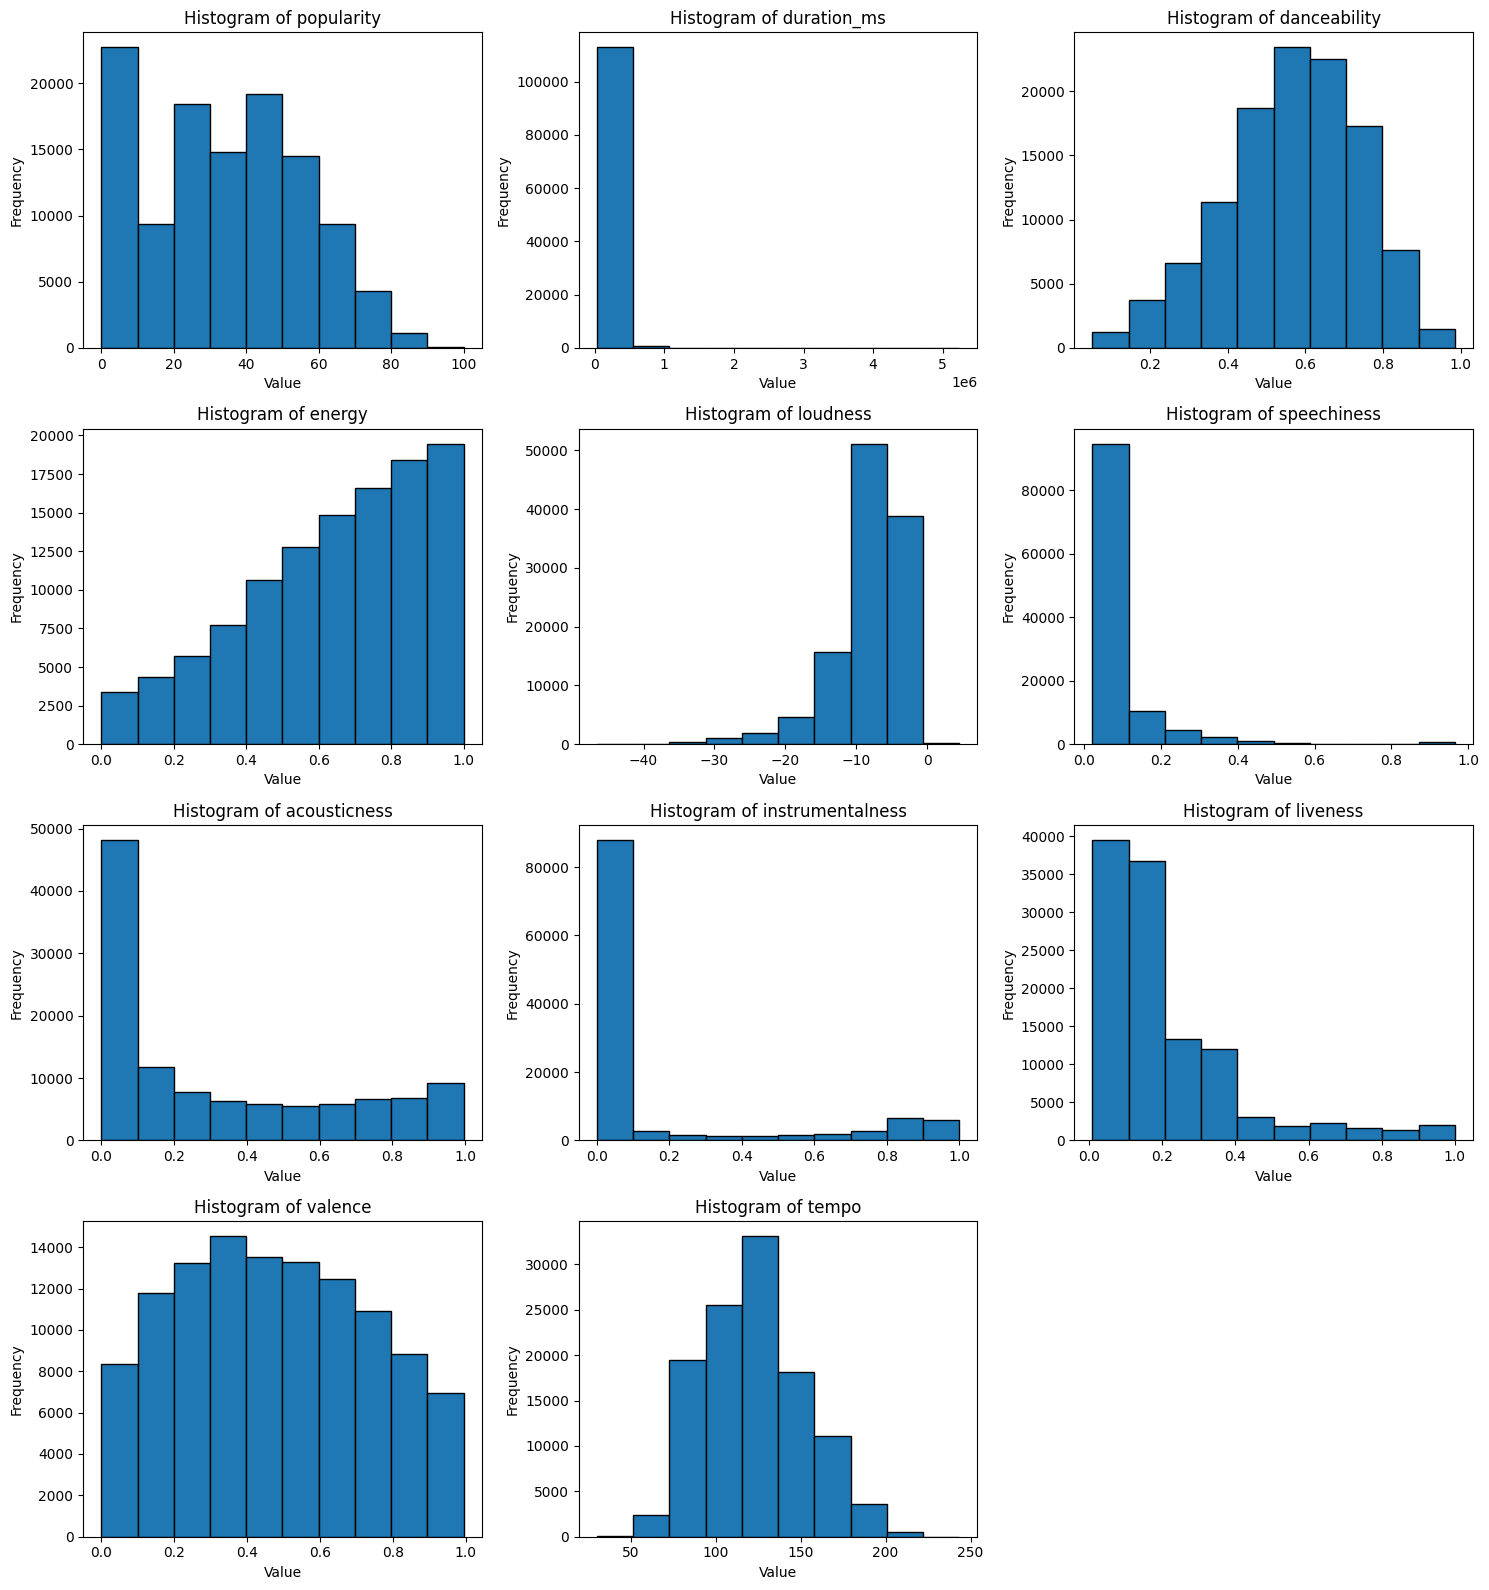

In [69]:
# Create subplots
num_columns = len(numeric_spotify.columns)
num_rows = (num_columns // 3) + (num_columns % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Create a histogram for each variable
for i, column in enumerate(numeric_spotify.columns):
    ax = axes[i]
    numeric_spotify[column].hist(bins=10, edgecolor='black', ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(False)

# Hiding unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Based on this, we definitely have a few variables that are extremely skewed. However, we decided not to transform the data to make it more normal because the most of the data is already on a scale between 0 and 1, and we didn't want to lose possible meaningful information. For example, in the description of the data, it describes the "speechiness" variable with "Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks", which would be lost if we were to correct the right-skew of the speechiness variable. 

We then decided to try to look at some relationships between variables by creating a correlation heatmap of every quantitative variable. 

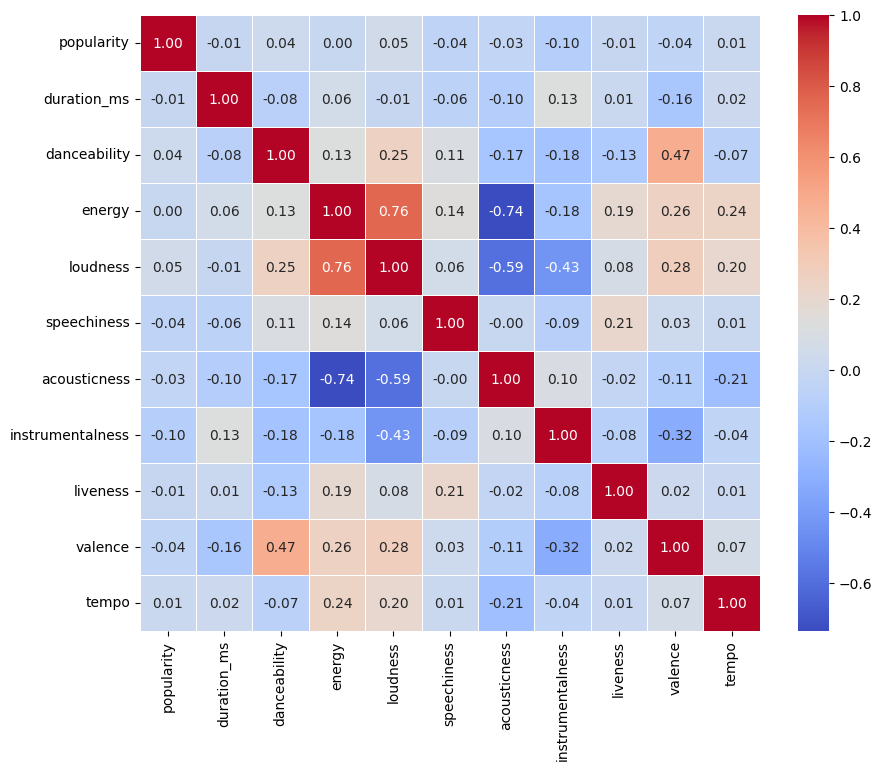

In [70]:
# Finding the correlation matrix
spotify_corr = numeric_spotify.corr()
spotify_corr

# Making correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spotify_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.show()

Based on the heatmap of correlations, we wanted to see a more detailed scatterplots of the features that were more correlated. So, we decided to plot more detailed scatterplots of the correlations larger than 0.4 or smaller than -0.4. We then plotted a linear and quadratic regression for each.

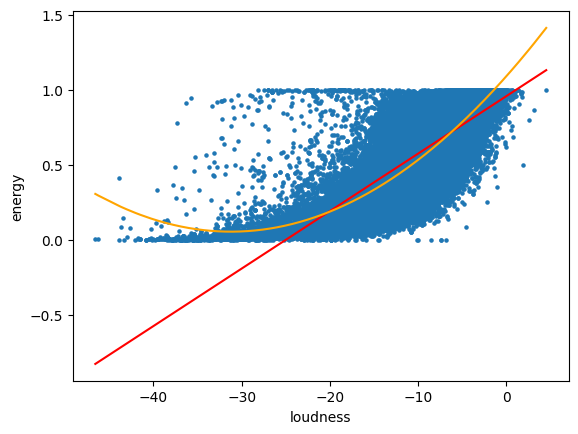

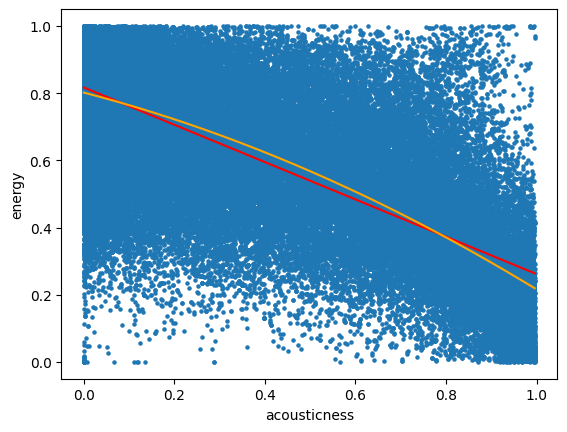

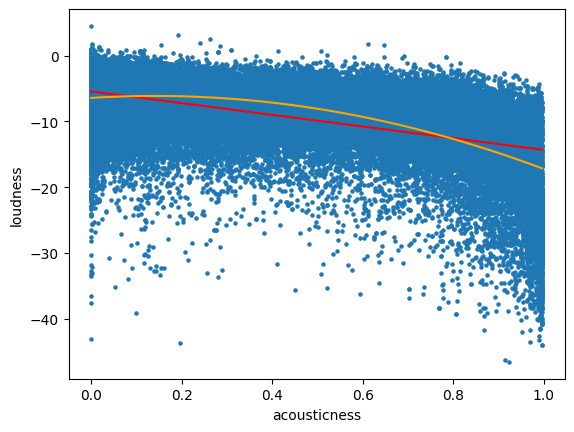

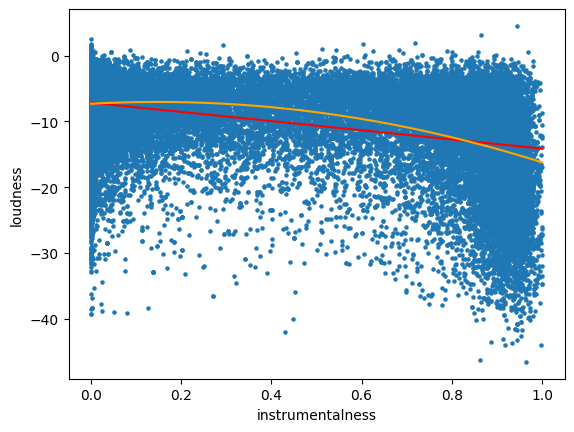

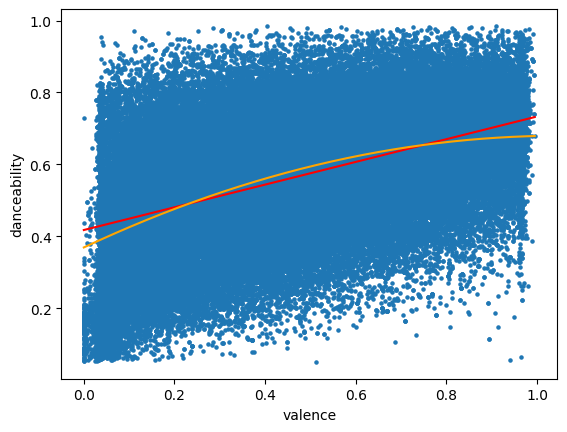

In [71]:
# Filtering out the pairs of higher correlated features
correlated_features = [
    ("loudness", "energy"),
    ("acousticness", "energy"),
    ("acousticness", "loudness"),
    ("instrumentalness", "loudness"),
    ("valence", "danceability"),
]

# Making scatterplots for each variable vs popularity
for (i, j) in correlated_features:
    plt.plot(np.unique(numeric_spotify[i]), np.poly1d(np.polyfit(numeric_spotify[i], numeric_spotify[j], 1))(np.unique(numeric_spotify[i])), color='red')
    plt.plot(np.unique(numeric_spotify[i]), np.poly1d(np.polyfit(numeric_spotify[i], numeric_spotify[j], 2))(np.unique(numeric_spotify[i])), color='orange')
    plt.scatter(numeric_spotify[i], numeric_spotify[j], s=5)
    plt.xlabel(i)
    plt.ylabel(j)
    plt.show()

Though the variability from our fitted lines seemed pretty high on our scatterplots, some of the shapes of the graphs were pretty interesting. In particular, we thought the shapes of the (acousticness vs loudness), (instrumentalness vs loudness), (acousticness vs energy), and (energy vs loudness) graphs seemed to have a pretty distinct shape. The variables may have some sort of relationship with each other, which we noted in case they played some part in later sections of our exploration in our project. 

We also looked into the categorical variables (excluding genre, which we will go into a more detailed exploration of later).

In [72]:
# Selecting the categories: key, mode, explicit, time signature
spotify_categories = spotify[categorical_columns + ['explicit']]
spotify_categories = spotify_categories.drop(columns='track_genre')

key_mapping = {
    0: 'C', 1: 'C♯/D♭', 2: 'D', 3: 'D♯/E♭', 4: 'E', 5: 'F', 6: 'F♯/G♭', 7: 'G',
    8: 'G♯/A♭', 9: 'A', 10: 'A♯/B♭', 11: 'B', -1: 'No Key Detected'
}

# Map the 'key' column to pitch names
spotify_categories['key'] = spotify_categories['key'].map(key_mapping)

# Mode is 0 or 1 (1 for Major, 0 for Minor)
spotify_categories['mode'] = spotify_categories['mode'].map({0: 'Minor', 1: 'Major'})

# Time signature
spotify_categories['time_signature'] = spotify_categories['time_signature'].astype(str)

spotify_categories

key   mode time_signature  explicit
0       C♯/D♭  Minor              4     False
1       C♯/D♭  Major              4     False
2           C  Major              4     False
3           C  Major              3     False
4           D  Major              4     False
...       ...    ...            ...       ...
113823      F  Major              5     False
113824      C  Minor              4     False
113825      C  Minor              4     False
113826      G  Major              4     False
113827  C♯/D♭  Minor              4     False

[113828 rows x 4 columns]

<Figure size 1200x1000 with 0 Axes>

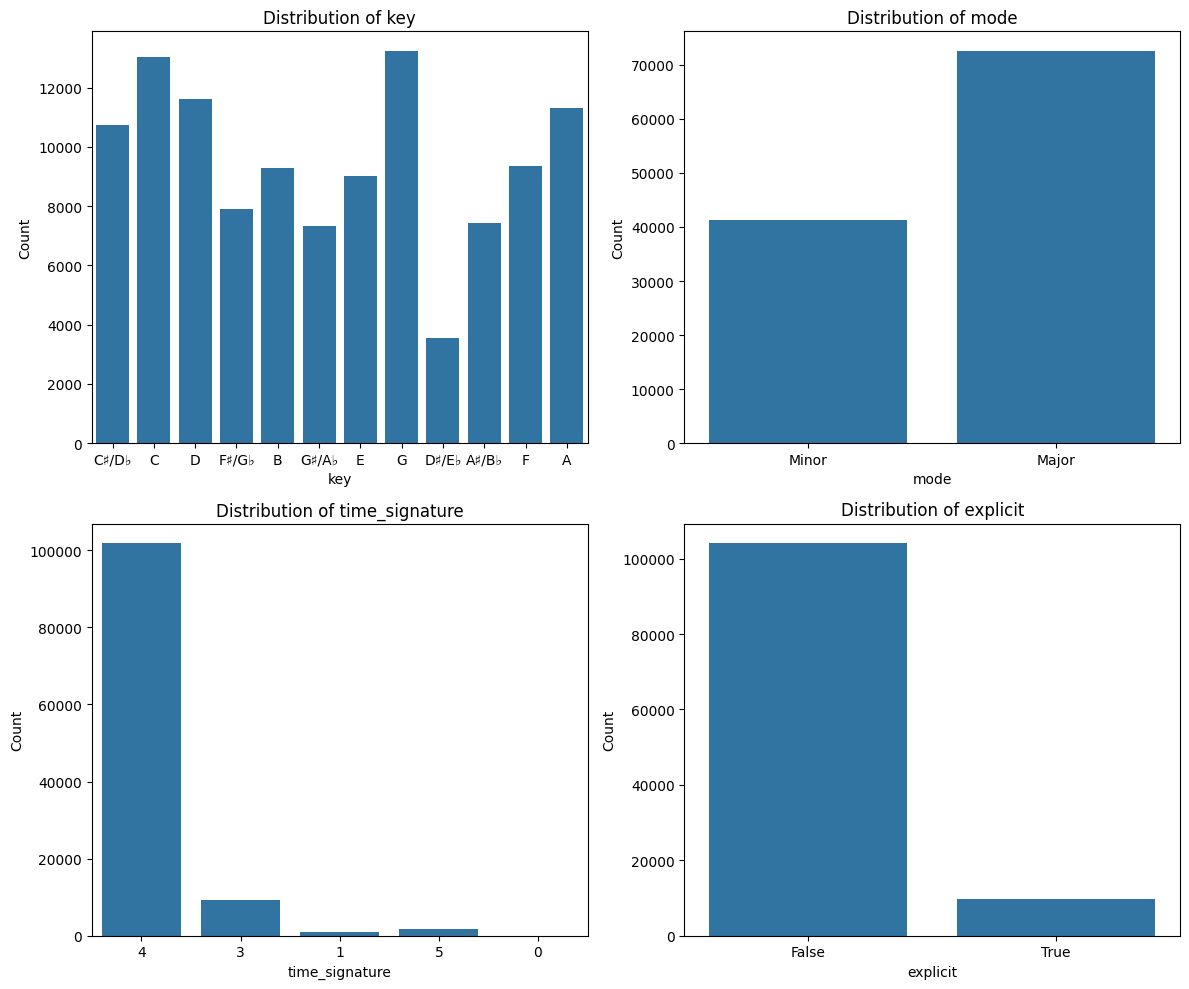

In [73]:
# Making barplots for each categorical value

# Create subplots for each categorical variable
plt.figure(figsize=(12, 10))
num_columns = len(spotify_categories.columns)
num_rows = (num_columns // 2) + (num_columns % 2 > 0)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
axes = axes.flatten()

# Loop through each categorical variable to create a bar plot
for i, column in enumerate(spotify_categories.columns):
    ax = axes[i]
    sns.countplot(x=column, data=spotify_categories, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.grid(False)

# Hiding unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Based on these visualizations it seems like the distributions for the key the song is in is fairly uniformly distributed, with D#/E♭ the least number of tracks. Additionally, most songs seem to be in major, have a 4/4 time signature, or non-explicit. 

After a more general exploration of some of the relationships and other features in our dataset, we decided to look closer into genre, the main focus of our project. 

In [74]:
genre_counts = spotify['track_genre'].value_counts()
print(genre_counts)

track_genre
acoustic       1000
afrobeat       1000
alt-rock       1000
alternative    1000
anime          1000
               ... 
classical       997
world-music     997
guitar          996
iranian         990
sleep           861
Name: count, Length: 114, dtype: int64


We have 114 different genres, and they all seem fairly split. In fact, our dataset seems to have 1000 samples for each genre, as the genres that have less than 1000 samples are genres that we cleaned data values from. We looked further into the specific genres and names.

In [75]:
genre_names = spotify['track_genre'].unique()
print(genre_names)

['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

We saw that some genres were a lot more specific than others, for example, the genre of "pop" versus "disney", so we kept that in mind while doing later investigations and processing that we might want to group certain similar genres together, like grouping rock genres, pop genres, jazz, genres, etc. 

We also looked at how some of the other variables were distributed grouped by track genre to see if certain genres had differentiable characteristics. 

In [76]:
temp = spotify['track_genre']
by_genres = numeric(spotify)
by_genres['track_genre'] = temp

by_genres.groupby('track_genre').mean()

popularity    duration_ms  danceability    energy   loudness  \
track_genre                                                                 
acoustic      42.483000  214896.957000      0.549593  0.435368  -9.447843   
afrobeat      24.399000  248412.791000      0.669580  0.702812  -7.789353   
alt-rock      33.943000  235455.907000      0.534493  0.754173  -6.191489   
alternative   24.337000  222016.180000      0.559927  0.720030  -6.078777   
ambient       44.151454  237478.207623      0.368974  0.237762 -18.584524   
...                 ...            ...           ...       ...        ...   
techno        39.042000  312311.477000      0.684348  0.746413  -8.077874   
trance        37.635000  269007.478000      0.583409  0.845272  -6.329711   
trip-hop      34.460000  274954.026000      0.634695  0.622363  -9.239915   
turkish       40.698000  219529.010000      0.616077  0.609804  -8.224722   
world-music   41.925777  294045.881645      0.415819  0.534177  -9.398517   

             speechiness  acousticness  instrumentalness  liveness   valence  \
track_genre                                                                    
acoustic        0.043247      0.566816          0.038336  0.153244  0.424023   
afrobeat        0.086579      0.270860          0.253483  0.184596  0.698619   
alt-rock        0.055071      0.122162          0.054097  0.210249  0.518260   
alternative     0.070101      0.147820          0.038159  0.201376  0.495570   
ambient         0.041687      0.776158          0.675362  0.129396  0.168002   
...                  ...           ...               ...       ...       ...   
techno          0.064212      0.081414          0.540038  0.159434  0.321878   
trance          0.079705      0.035870          0.423501  0.234357  0.276881   
trip-hop        0.076303      0.225615          0.383761  0.190342  0.478069   
turkish         0.105087      0.321125          0.035603  0.180750  0.462314   
world-music     0.041894      0.299980          0.089768  0.250248  0.251048   

                  tempo  
track_genre              
acoustic     119.010624  
afrobeat     119.213337  
alt-rock     124.634404  
alternative  122.232394  
ambient      111.447471  
...                 ...  
techno       128.255482  
trance       133.276726  
trip-hop     118.743616  
turkish      120.367607  
world-music  121.758988  

[114 rows x 11 columns]

In order to better visualize these results, we decided to group the genres even further (as visualizing the differences between 114 grouped genres may be unclear). To do so, we manually grouped the genres into 10 more over-arching, general genres:

- **Pop:**  cantopop, j-pop, k-pop, mandopop, pop, indie-pop, power-pop, pop-film, synth-pop  
- **Rock:**  alt-rock, alternative, hard-rock, punk-rock, psych-rock, rock, rock-n-roll, grunge, emo, rockabilly, guitar  
- **Metal:**  black-metal, death-metal, heavy-metal, metal, metalcore, grindcore  
- **Electronic:**  edm, electro, electronic, house, garage, techno, trance, dubstep, idm, minimal-techno, progressive-house, chicago-house, deep-house, detroit-techno, disco, drum-and-bass, dub, club, dance, dancehall  
- **Hip-Hop:**  hip-hop, rap, r-n-b, breakbeat  
- **Jazz:**  jazz, blues, soul, funk  
- **Classical:**  classical, opera, piano  
- **World:**  afrobeat, brazil, british, latin, latino, samba, salsa, reggae, reggaeton, tango, world-music, indian, iranian, turkish, malay, mpb, pagode, forro, french, german, spanish, swedish  
- **Folk:**  folk, bluegrass, country, singer-songwriter, songwriter, honky-tonk  
- **Misc:**  acoustic, ambient, anime, children, chill, comedy, disney, happy, party, study, sleep, show-tunes, new-age, kids, industrial, gospel, goth, groove, hardcore, hardstyle, indie, j-dance, j-idol, j-rock, punk, romance, sad, sertanejo, ska, trip-hop  


In [77]:
original_data = pd.read_csv('spotify.csv')

genre_groups = {
    'pop': ['cantopop', 'j-pop', 'j-idol', 'k-pop', 'mandopop', 'pop', 'indie-pop', 'power-pop', 'pop-film', 'synth-pop'],
    'rock': ['alt-rock', 'alternative', 'hard-rock', 'indie', 'punk', 'j-rock', 'punk-rock', 'psych-rock', 'rock', 'rock-n-roll', 'grunge', 'emo', 'rockabilly', 'guitar'],
    'metal': ['black-metal', 'death-metal', 'heavy-metal', 'metal', 'metalcore', 'grindcore'],
    'electronic': ['edm', 'electro', 'electronic', 'house', 'garage', 'j-dance', 'hardcore', 'hardstyle', 'industrial', 'techno', 'trance', 'dubstep', 'idm', 'minimal-techno', 'progressive-house', 'chicago-house', 'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub', 'club', 'dance', 'dancehall'],
    'hip-hop': ['hip-hop', 'rap', 'r-n-b', 'breakbeat', 'trip-hop'],
    'jazz': ['jazz', 'blues', 'soul', 'funk', 'ska', 'gospel'],
    'classical': ['classical', 'opera', 'piano'],
    'world': ['afrobeat', 'brazil', 'sertanejo', 'british', 'latin', 'latino', 'samba', 'salsa', 'reggae', 'reggaeton', 'tango', 'world-music', 'indian', 'iranian', 'turkish', 'malay', 'mpb', 'pagode', 'forro', 'french', 'german', 'spanish', 'swedish'],
    'folk': ['folk', 'bluegrass', 'country', 'singer-songwriter', 'songwriter', 'honky-tonk'],
    'misc': ['acoustic', 'ambient', 'anime', 'children', 'chill', 'comedy', 'disney', 'happy', 'party', 'study', 'sleep', 'show-tunes', 'new-age', 'kids', 'goth', 'groove', 'romance', 'sad']
}

genre_map = dict()
for genre, l in genre_groups.items():
    for original in l:
        genre_map[original] = genre

data = original_data.copy()
data['track_genre'] = data['track_genre'].map(genre_map)

data.to_csv(
    "grouped_cleaned_spotify.csv",
    index=False
)

In [78]:
grouped_spotify = pd.read_csv("grouped_cleaned_spotify.csv")
grouped_spotify['track_genre'].value_counts()

track_genre
electronic    24000
world         22984
misc          17855
rock          13996
pop            9999
metal          6000
folk           6000
jazz           5999
hip-hop        4000
classical      2995
Name: count, dtype: int64

Though now we have some imbalance between the different genres, it is much easier for us to visualize the values. Looking again at the means:

In [79]:
temp = grouped_spotify['track_genre']
by_grouped_genres = numeric(grouped_spotify)
by_grouped_genres['track_genre'] = temp

grouped_genre_means = by_grouped_genres.groupby('track_genre').mean()
grouped_genre_means

popularity    duration_ms  danceability    energy   loudness  \
track_genre                                                                 
classical     27.671452  223765.185309      0.383762  0.275876 -16.901773   
electronic    32.682375  244199.154417      0.628392  0.748102  -6.786162   
folk          28.781833  214844.595833      0.557295  0.484704  -9.592910   
hip-hop       32.257250  255499.212000      0.657858  0.699074  -7.198840   
jazz          28.944157  226728.059177      0.568563  0.578545  -8.072706   
metal         30.441833  238321.365167      0.375544  0.893222  -5.626057   
misc          32.046766  202753.826211      0.544729  0.519480 -11.052483   
pop           41.354135  236116.865087      0.576878  0.647109  -7.206672   
rock          36.582809  216122.028079      0.531166  0.673804  -7.515469   
world         33.082884  231900.404760      0.600875  0.635310  -7.881580   

             speechiness  acousticness  instrumentalness  liveness   valence  \
track_genre                                                                    
classical       0.048077      0.806379          0.432656  0.176999  0.303223   
electronic      0.092085      0.122595          0.249558  0.190737  0.432817   
folk            0.046643      0.528443          0.048824  0.178637  0.517899   
hip-hop         0.095396      0.205441          0.200120  0.216372  0.534306   
jazz            0.074014      0.385527          0.028089  0.215736  0.539197   
metal           0.098494      0.017465          0.241315  0.251464  0.296137   
misc            0.123619      0.488473          0.250852  0.230444  0.411343   
pop             0.061161      0.313732          0.028029  0.185500  0.511655   
rock            0.062589      0.258902          0.072948  0.204043  0.530961   
world           0.082780      0.372472          0.082835  0.243521  0.547976   

                  tempo  
track_genre              
classical    110.627554  
electronic   126.276463  
folk         120.840527  
hip-hop      123.145587  
jazz         119.278760  
metal        126.118669  
misc         117.992933  
pop          124.357350  
rock         124.747857  
world        120.740060

In [80]:
ranges = grouped_genre_means.max() - grouped_genre_means.min()
ranges

popularity             13.682683
duration_ms         52745.385789
danceability            0.282314
energy                  0.617346
loudness               11.275715
speechiness             0.076976
acousticness            0.788914
instrumentalness        0.404627
liveness                0.074465
valence                 0.251839
tempo                  15.648908
dtype: float64

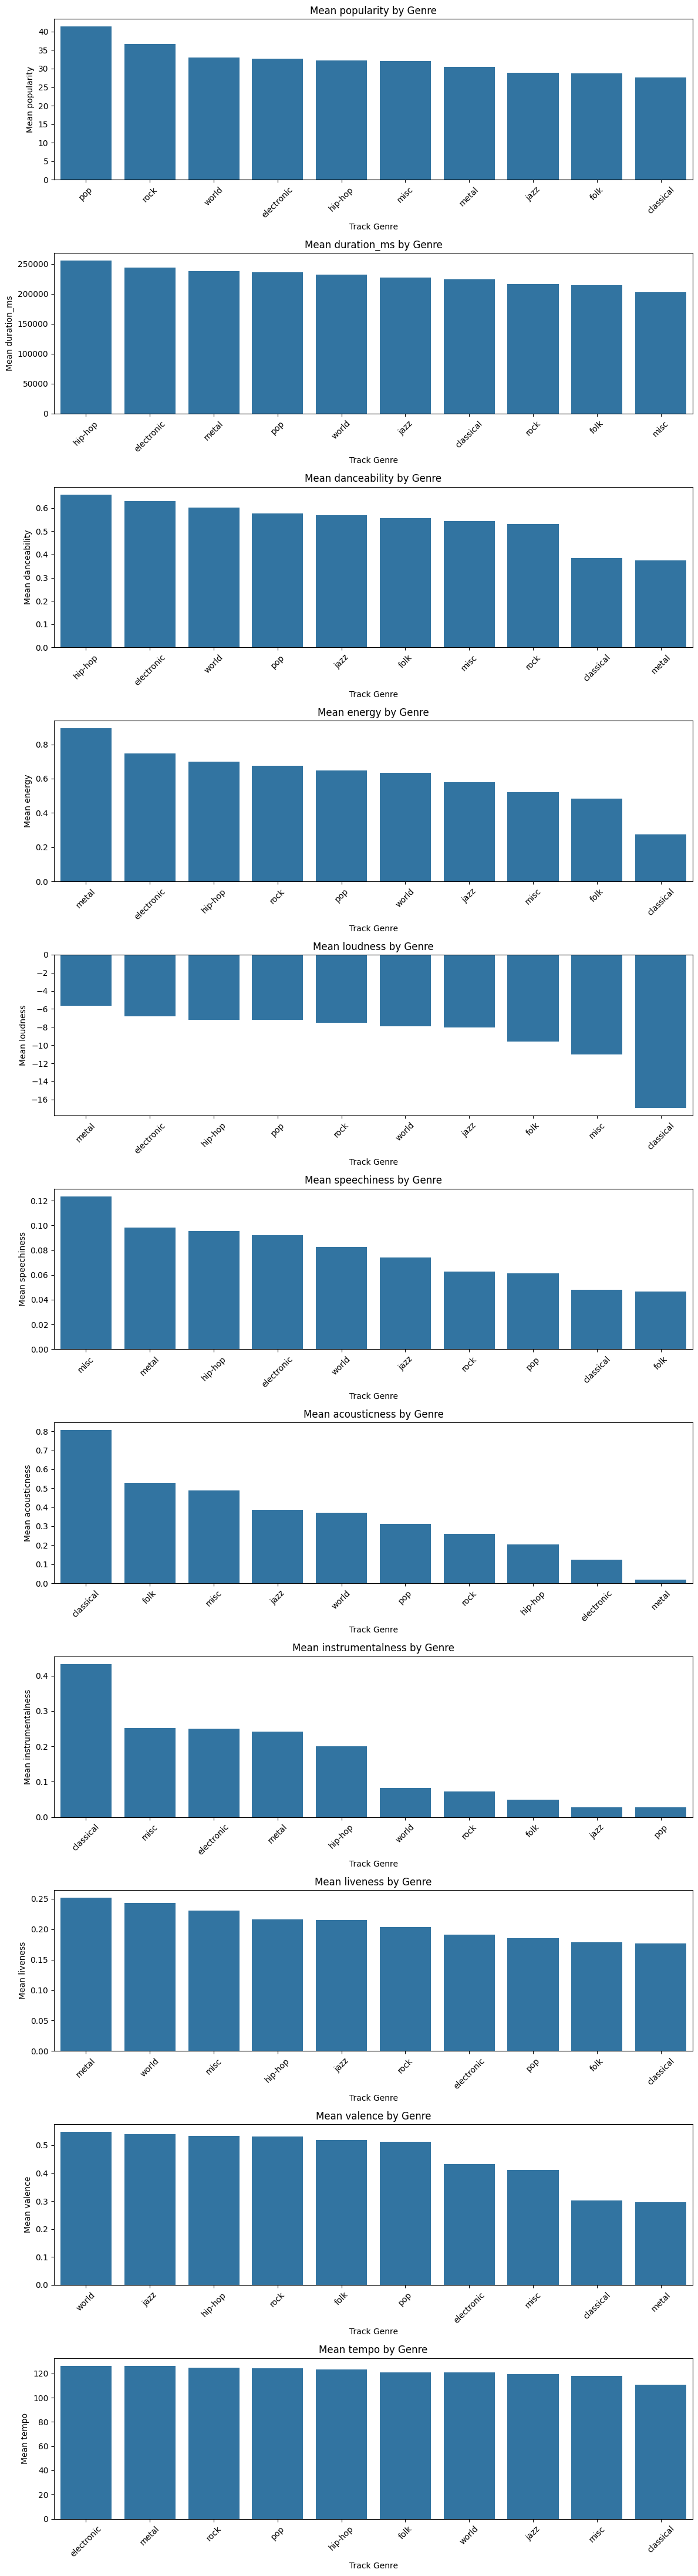

In [81]:
num_vars = len(grouped_genre_means.columns)
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, num_vars * 4))

# Plot each variable as a barplot
for i, (column, ax) in enumerate(zip(grouped_genre_means.columns, axes)):
    sorted_data = grouped_genre_means[column].sort_values(ascending=False) # sort descending

    sns.barplot(
        x=sorted_data.index,
        y=sorted_data.values,
        ax=ax,
    )
    ax.set_title(f'Mean {column} by Genre')
    ax.set_xlabel('Track Genre')
    ax.set_ylabel(f'Mean {column}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

From the above visualizations, we can make a few interesting observations about each variable:
- Pop music seems to be the most popular, though not necessarily by very much (around 5 points difference from rock).
- Duration doesn't seem to have that much variability across genres when considering the range of the means is about 43000ms, which is about a 42 second difference. However, hip-hop songs seem to be the longest in duration compared to other genres. 
- Classical and metal tracks seem to score lower on danceability scores compared to other genres, and hip-hop is the highest for danceability.
- Metal scores very high for energy levels, while classical seems to score lower.
- Similarly, metal scores high for loudness, while classical scores much lower. In this variable, loudness, the difference between classical and the rest of the variables is much more apparent.
- For the speechiness variable, folk and classical have the least amount of speechiness, while miscellaneous genres have the most.
- For acousticness, classical music scores very high while metal scores extremely low.
- With instrumentalness, classical music once again scores high, with pop and jazz scoring low.
- There doesn't seem to be too large of a difference in liveness across the variables, though metal does score the highest while classical scores the lowest.
- Surprisingly, metal and classical both score low on valence, with jazz, hip-hop, and world tracks scoring higher.
- Tempo seems to be fairly uniformly distributed across the genres, with classical and jazz barely scoring lower than the other genres.

In summary, it seems like classical tracks and metal tracks have the largest distinction between their variables, and the variables acousticness and instrumentalness seem to have the most variance across genres.

To investigate our genres in our dataset further, such as which features may play a role in the labelling of genres and if there's a way for us to predict the genre of a song based on its features, we can prepare our data for further model and training. We decided we didn't need to do any feature engineering since several of our variables already ranged from 0 to 1, some with meaningful values (as discussed in the cleaning section). We also didn't add any extra data through data augmentation because we already had over 100k samples, which we felt would be sufficient in our investigation. 

In order to prepare our data for more learning models, we split it into training, validation, and testing datasets (60-20-20). an example of how we split our data is in the code below, but we re-split it for each model for the sake of simplicity. We did this both for our original cleaned dataset and also our dataset grouped by our 10 generalized genres.

In [82]:
random_seed = 42

# encode categorical categories
for column in categorical_columns:
    spotify[column] = pd.Categorical(spotify[column])

# First split: separate out 20% for the test set
spotify_train_val, spotify_test = train_test_split(spotify, test_size=0.2, random_state=random_seed)
# Second split: separate remaining 80% into 60% training and 20% validation
spotify_train, spotify_val = train_test_split(spotify_train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

# Grouped genre dataset, grouped_spotify
# First split: separate out 20% for the test set
grouped_spotify_train_val, grouped_spotify_test = train_test_split(grouped_spotify, test_size=0.2, random_state=random_seed)
# Second split: separate remaining 80% into 60% training and 20% validation
grouped_spotify_train, grouped_spotify_val = train_test_split(grouped_spotify_train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

A summary of the datasets that result from the train-validation-test splitting is below:

Original 114 genre dataset:
- `spotify_train` (60% of the total dataset)
- `spotify_val` (20% of the total dataset)
- `spotify_test` (20% of the total dataset)

Re-grouped 10 genre dataset:
- `grouped_spotify_train` (60% of the total dataset)
- `grouped_spotify_val` (20% of the total dataset)
- `grouped_spotify_test` (20% of the total dataset)

In [83]:
# This code does OHE and removed genre from grouped_spotify
response_variable = "track_genre"
ohe_column_transformer_wo_genre = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), [col for col in categorical_columns if col != response_variable]),
        ('string', 'drop', string_columns),
        ('numeric', 'passthrough', [col for col in spotify.columns if col != response_variable and col not in string_columns])
    ],
    verbose_feature_names_out=False
)
ohe_column_transformer_wo_genre.set_output(transform="pandas")
ohe_column_transformer_wo_genre.fit(grouped_spotify)

ohe_grouped_column_transformer_wo_genre = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), [col for col in categorical_columns if col != response_variable]),
        ('string', 'drop', string_columns),
        ('numeric', 'passthrough', [col for col in grouped_spotify.columns if col != response_variable and col not in string_columns])
    ],
    verbose_feature_names_out=False
)
ohe_grouped_column_transformer_wo_genre.set_output(transform="pandas")
ohe_grouped_column_transformer_wo_genre.fit(grouped_spotify)

ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False),
                                 ['key', 'mode', 'time_signature']),
                                ('string', 'drop',
                                 ['track_id', 'artists', 'album_name',
                                  'track_name']),
                                ('numeric', 'passthrough',
                                 ['popularity', 'duration_ms', 'explicit',
                                  'danceability', 'energy', 'key', 'loudness',
                                  'mode', 'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'time_signature'])],
                  verbose_feature_names_out=False)

## Linear + Polynomial Regression

For our linear regression, we chose to use the `energy` variable as our response variable, as it seemed to have the most relationships with other variables based on our correlation heatmap during our EDA, and we were interested in finding out what may contribute to the energy of a song.

To find out our predictor variables, we used forward feature selection to see which predictors may be most correlated with our response variable (energy).

To find out our predictor variables, we used forward feature selection to see which predictors may be most correlated with our response variable (energy).

In [52]:
response = "energy" # this was chosen based on correlation heatmap

# Making sure only numeric variables are used:
num_spotify_train = numeric(spotify_train)
num_spotify_val = numeric(spotify_val)
num_spotify_test = numeric(spotify_test)

# Reshape the data to fit the model
X_train = num_spotify_train.drop(columns=response)
y = num_spotify_train[response]

lin_reg = LinearRegression()

# Select features
selector = SequentialFeatureSelector(
    lin_reg,
    n_features_to_select='auto',
    direction='forward',
    scoring='r2',
    cv = 5
)

selector.fit(X_train, y)
selected_features = selector.get_feature_names_out(X_train.columns)
print("Selected Features: ", selected_features)

Selected Features:  ['loudness' 'acousticness' 'instrumentalness' 'liveness' 'valence']


Based on this we found that `'loudness', 'acousticness', 'instrumentalness', 'liveness',` and `'valence'` were our selected features, and graphed these with energy as the response variable to investigate the relationships.

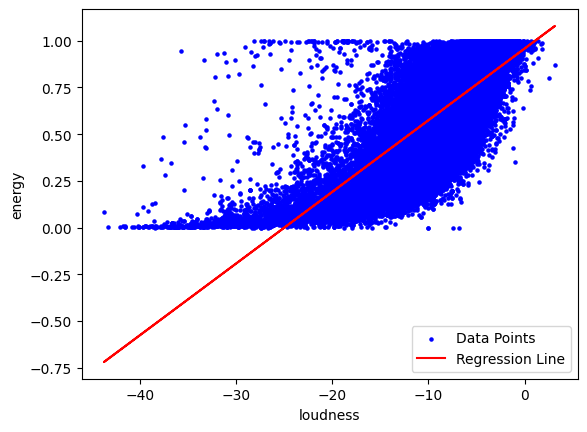

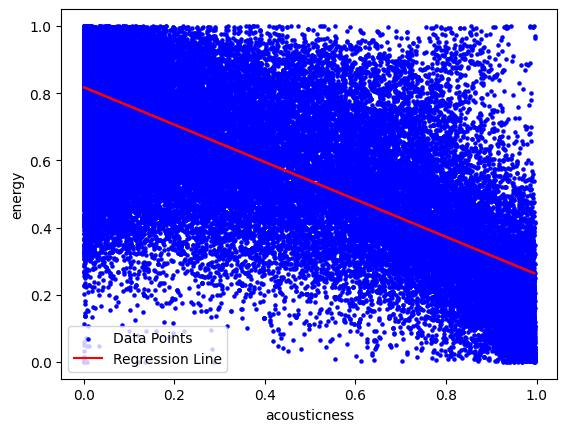

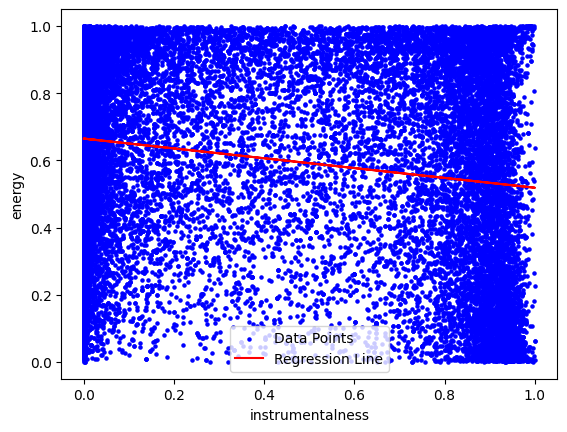

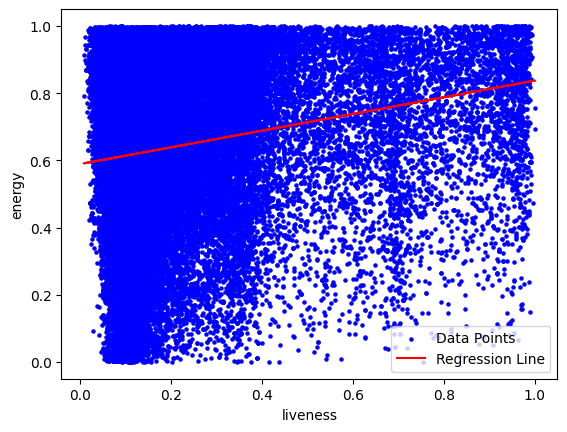

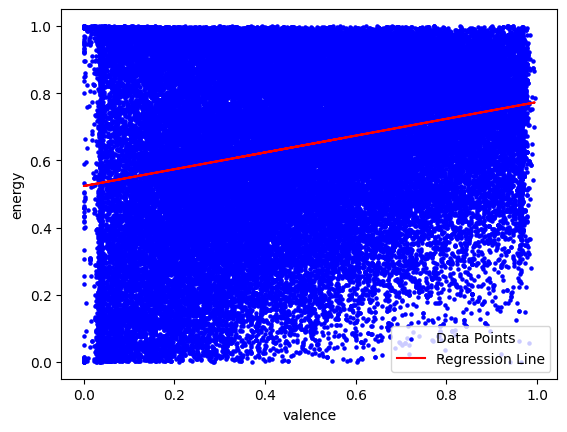

In [53]:

X = selector.transform(X_train)

X_test = selector.transform(num_spotify_test.drop(columns=response))
y_test = num_spotify_test[response]

X_val = selector.transform(num_spotify_val.drop(columns=response))
y_val = num_spotify_val[response]

lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

# Plotting scatter plot with a regression line
for feature in selected_features:
    # Scatter plot of the data points
    plt.scatter(X_train[feature], y, color='blue', s=5, label="Data Points")

    # Calculate the regression line
    feature_values = X_train[feature].values.reshape(-1, 1)
    temp_model = LinearRegression()
    temp_model.fit(feature_values, y)
    y_line = temp_model.predict(feature_values)

    # Plot the regression line
    plt.plot(feature_values, y_line, color='red', label="Regression Line")

    plt.xlabel(feature)
    plt.ylabel(response)
    plt.legend()

    plt.show()

Based on these graphs, some of our correlations are likely not linear, and others likely have a large amount of variance. We calculated the evaluation metrics for our linear regression model to see how it was performing. 

In [54]:
# Calculating Evaluation Metrics:
y_val_pred = lin_reg.predict(X_val) # Predict on validation set

# Calculate metrics for the training set
train_mse = mean_squared_error(y, y_pred) # Mean squared error
train_rmse = np.sqrt(train_mse) # Root mean squared error
train_mae = mean_absolute_error(y, y_pred) # Mean average error
train_mad = np.mean(np.abs(y - y_pred))  # Mean absolute deviation
train_r2 = r2_score(y, y_pred) # R^2 (coefficient of determination)

# Calculate metrics for the validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mad = np.mean(np.abs(y_val - y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

# Print Results:
print(f"Training MSE: {train_mse}, rMSE: {train_rmse}, MAE: {train_mae}, MAD: {train_mad}, R²: {train_r2}")
print(f"Validation MSE: {val_mse}, rMSE: {val_rmse}, MAE: {val_mae}, MAD: {val_mad}, R²: {val_r2}")

# bias variance
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    lin_reg,
    X, y.values,
    X_test, y_test.values,
    loss='mse',
    random_seed=123
)

print(f"Loss, variance, and bias: {avg_expected_loss}, {avg_bias}, {avg_var}")

Training MSE: 0.01591975141780648, rMSE: 0.12617349728768906, MAE: 0.0986015100486982, MAD: 0.0986015100486982, R²: 0.7477655716969742
Validation MSE: 0.016297699800804963, rMSE: 0.1276624447549277, MAE: 0.09952336547066755, MAD: 0.09952336547066755, R²: 0.7385932898496084
Loss, variance, and bias: 0.01592652204991807, 0.015924634631379178, 1.8874185388953818e-06


Based on the evaluation metrics we calculated above, our model seems to fit the data decently. Most notably, the MSE is very low and close together for the training and validation sets, 0.016 for both. This suggests there is low error and the model fits the data.

The R^2 values (0.743 and 0.746) are moderately strong, which indicates that the model is explaining a good amount of the variance in the dependent variable (energy). However, we know based on the graphs (that do not look very linear) that we could probably improve our model if we were to use a different model, such as a polynomial regression. However, since the exploration on energy doesn't necessarily contribute to our project goal, we decided to switch directions and look further into genre instead.

Though linear/polynomial regression isn't necessarily a model that aligns with our project goals (which focuses on investigating and predicting the genres, a categorical variable, or different songs), and thus we chose not to include it in our main report, we still did some light explorations of the relationships between our different variables for different genres using regression. 

In [55]:
# Make a dictionary for the data for efficiency
genre_groups = {genre: group for genre, group in spotify.groupby('track_genre')}
grouped_genre_groups = {genre: group for genre, group in grouped_spotify.groupby('track_genre')}

print(np.unique(spotify["track_genre"]))
print(np.unique(grouped_spotify['track_genre']))

['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie' 'indie-pop' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop' 'pop-film' 'power-pop'
 'progressive-house' 'psych-rock' 'punk' 'punk-rock' 'r-n-b' 'reggae'
 'reggaeton' 'rock' 'rock-n-roll' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

In [56]:
# Selecting only the numeric features
numeric_spotify = spotify.select_dtypes(include=[np.number])
numeric_spotify = numeric_spotify.loc[:, ~numeric_spotify.columns.isin(["mode", "key", "time_signature"])]
numeric_spotify

popularity  duration_ms  danceability  energy  loudness  speechiness  \
0               73       230666         0.676  0.4610    -6.746       0.1430   
1               55       149610         0.420  0.1660   -17.235       0.0763   
2               57       210826         0.438  0.3590    -9.734       0.0557   
3               71       201933         0.266  0.0596   -18.515       0.0363   
4               82       198853         0.618  0.4430    -9.681       0.0526   
...            ...          ...           ...     ...       ...          ...   
113823          21       384999         0.172  0.2350   -16.393       0.0422   
113824          22       385000         0.174  0.1170   -18.318       0.0401   
113825          22       271466         0.629  0.3290   -10.895       0.0420   
113826          41       283893         0.587  0.5060   -10.889       0.0297   
113827          22       241826         0.526  0.4870   -10.204       0.0725   

        acousticness  instrumentalness  liveness  valence    tempo  
0             0.0322          0.000001    0.3580   0.7150   87.917  
1             0.9240          0.000006    0.1010   0.2670   77.489  
2             0.2100          0.000000    0.1170   0.1200   76.332  
3             0.9050          0.000071    0.1320   0.1430  181.740  
4             0.4690          0.000000    0.0829   0.1670  119.949  
...              ...               ...       ...      ...      ...  
113823        0.6400          0.928000    0.0863   0.0339  125.995  
113824        0.9940          0.976000    0.1050   0.0350   85.239  
113825        0.8670          0.000000    0.0839   0.7430  132.378  
113826        0.3810          0.000000    0.2700   0.4130  135.960  
113827        0.6810          0.000000    0.0893   0.7080   79.198  

[113828 rows x 11 columns]

We'll start with using linear regression. We looked at the linear regression between each of the 114 genres and each other variable to see if there seemed to be any strong relationships. We investigated the R^2, variance, and bias for the fits.

In [57]:
numeric_dict = {
    'popularity': 0,
    'duration_ms': 0,
    'danceability': 0,
    'energy': 0,
    'loudness': 0,
    'speechiness': 0,
    'acousticness': 0,
    'instrumentalness': 0,
    'liveness': 0,
    'valence': 0,
    'tempo': 0
}

In [58]:
# Modeling linear regression of genres to all other variables

highest_r2 = 0
highest_r2_genre = ''
highest_r2_response = ''

for genre in genre_groups:
    df = genre_groups.get(genre, pd.DataFrame())
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = numeric_df.loc[:, ~numeric_df.columns.isin(["mode", "key", "time_signature"])]

    linear_reg = LinearRegression()

    # Select features
    selector = SequentialFeatureSelector(
            linear_reg,
            n_features_to_select='auto',
            direction='forward',
            scoring='r2',
            cv = 5
        )

    max_train_r2 = 0
    max_validation_r2 = 0
    max_response = ''

    for x in numeric_df.columns:
        random_seed = 42
        response = x
        # Splitting the data
        # First split: separate out 20% for the test set
        train_val, test = train_test_split(numeric_df, test_size=0.2, random_state=random_seed)

        # Second split: separate remaining 80% into 60% training and 40% validation
        train, val = train_test_split(train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

        # Reshape the data to fit the model
        X_train = train.drop(columns=response)
        y = train[response]


        selector.fit(X_train, y)
        selected_features = selector.get_feature_names_out(X_train.columns)

        # Transform data sets
        X = selector.transform(X_train)

        X_test = selector.transform(test.drop(columns=response))
        y_test = test[response]

        X_val = selector.transform(val.drop(columns=response))
        y_val = val[response]

        linear_reg.fit(X, y)
        y_pred = linear_reg.predict(X)

        # Calculating Evaluation Metrics:
        y_val_pred = linear_reg.predict(X_val)

        # Calculate metrics for the training set
        train_mse = mean_squared_error(y, y_pred) # Mean squared error
        train_rmse = np.sqrt(train_mse) # Root mean squared error
        train_mae = mean_absolute_error(y, y_pred) # Mean average error
        train_mad = np.mean(np.abs(y - y_pred))  # Mean absolute deviation
        train_r2 = r2_score(y, y_pred) # R^2 (coefficient of determination)

        # Calculate metrics for the validation set
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_mad = np.mean(np.abs(y_val - y_val_pred))
        val_r2 = r2_score(y_val, y_val_pred)

        # Print Results:
        print("")
        print(f"{genre} x {response} - Training MSE: {train_mse}, rMSE: {train_rmse}, MAE: {train_mae}, MAD: {train_mad}, R²: {train_r2}")
        print(f"{genre} x {response} - Validation MSE: {val_mse}, rMSE: {val_rmse}, MAE: {val_mae}, MAD: {val_mad}, R²: {val_r2}")

        if val_r2 > max_validation_r2:
            max_train_r2 = train_r2
            max_validation_r2 = val_r2
            max_response = x

        # bias variance
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            linear_reg,
            X, y.values,
            X_test, y_test.values,
            loss='mse',
            random_seed=123
        )

        print(f"{genre} x {response} - Loss, Variance, and Bias: {avg_expected_loss}, {avg_bias}, {avg_var}")
    print("")
    print(f"Response Variable with the Highest Validation R^2 for {genre}: {max_response}")
    print(f"Train R^2 for {max_response} in {genre}: {max_train_r2}")
    print(f"Validation R^2 for {max_response} in {genre}: {max_validation_r2}")
    numeric_dict[max_response]+=1
    print("")
    print("-----")

    # Storing the variable / genre with the highest R^2 values
    if(max_validation_r2 > highest_r2):
        highest_r2 = max_validation_r2
        highest_r2_genre = genre
        highest_r2_response = response

print(numeric_dict)
print("")
print(f"The highest Validation R^2 was between {genre} and {response}, with a score of {highest_r2}.")


acoustic x popularity - Training MSE: 240.1301887882887, rMSE: 15.496134640234922, MAE: 11.938610575897624, MAD: 11.938610575897624, R²: 0.08202801149089911
acoustic x popularity - Validation MSE: 308.21524154571523, rMSE: 17.556059966453613, MAE: 13.063805517662317, MAD: 13.063805517662317, R²: 0.033764403328190196
acoustic x popularity - Loss, Variance, and Bias: 264.9212703269596, 262.7144247551956, 2.206845571764101

acoustic x duration_ms - Training MSE: 2334862607.908044, rMSE: 48320.416056859896, MAE: 37180.19783090932, MAD: 37180.19783090932, R²: 0.19322722623809274
acoustic x duration_ms - Validation MSE: 3164494809.2628603, rMSE: 56253.84261775244, MAE: 40015.50441524245, MAD: 40015.50441524245, R²: 0.06634947269482883
acoustic x duration_ms - Loss, Variance, and Bias: 3063600128.744078, 3028701412.797077, 34898715.94700093

acoustic x danceability - Training MSE: 0.012414960421764605, rMSE: 0.11142244128435082, MAE: 0.08970008412696967, MAD: 0.08970008412696967, R²: 0.15643

Based on our linear regression investigation, it seems like energy tended to have the highest validation correlation with various genres, with 101 genres that were correlated the most with energy compared to other features. Following energy, 11 genres were more correlated with loudness, and 1 genre for both speechiness and valence had highest correlations. The relationship that seemed to have the strongest linear correlation was between the world-music genre's variables, with the tempo variable as the response.

We decided to also try a quadratic regression on our data to see if the increase in degree may have any significant effects. 

In [59]:
# Define the degree of the polynomial, in this case, quadratic
degree = 2

# Create a pipeline for Polynomial Regression
poly_reg = make_pipeline(
    PolynomialFeatures(degree=degree),
    LinearRegression()
)

In [60]:
# Modeling quadratic regression (degree = 2) of genres to all other variables

numeric_dict2 = {
    'popularity' : 0,
    'duration_ms' : 0,
    'danceability' : 0,
    'energy' : 0,
    'loudness' : 0,
    'speechiness' : 0,
    'acousticness' : 0,
    'instrumentalness' : 0,
    'liveness' : 0,
    'valence' : 0,
    'tempo' : 0
}

highest_r2 = 0
highest_r2_genre = ''
highest_r2_response = ''

for genre in genre_groups:
    df = genre_groups.get(genre, pd.DataFrame())
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = numeric_df.loc[:, ~numeric_df.columns.isin(["mode", "key", "time_signature"])]

    # Select features
    selector = SequentialFeatureSelector(
            linear_reg,
            n_features_to_select='auto',
            direction='forward',
            scoring='r2',
            cv = 5
        )

    max_train_r2 = 0
    max_validation_r2 = 0
    max_response = ''

    for x in numeric_df.columns:
        random_seed = 42
        response = x
        # Splitting the data
        # First split: separate out 20% for the test set
        train_val, test = train_test_split(numeric_df, test_size=0.2, random_state=random_seed)

        # Second split: separate remaining 80% into 60% training and 40% validation
        train, val = train_test_split(train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

        # Reshape the data to fit the model
        X_train = train.drop(columns=response)
        y = train[response]


        selector.fit(X_train, y)
        selected_features = selector.get_feature_names_out(X_train.columns)

        # Transform data sets
        X = selector.transform(X_train)

        X_test = selector.transform(test.drop(columns=response))
        y_test = test[response]

        X_val = selector.transform(val.drop(columns=response))
        y_val = val[response]

        # Fit the Polynomial Regression model
        poly_reg.fit(X, y)
        y_pred = poly_reg.predict(X)

        # Calculating Evaluation Metrics:
        y_val_pred = poly_reg.predict(X_val)

        # Calculate metrics for the training set
        train_mse = mean_squared_error(y, y_pred) # Mean squared error
        train_rmse = np.sqrt(train_mse) # Root mean squared error
        train_mae = mean_absolute_error(y, y_pred) # Mean average error
        train_mad = np.mean(np.abs(y - y_pred))  # Mean absolute deviation
        train_r2 = r2_score(y, y_pred) # R^2 (coefficient of determination)

        # Calculate metrics for the validation set
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_mad = np.mean(np.abs(y_val - y_val_pred))
        val_r2 = r2_score(y_val, y_val_pred)

        # Print Results:
        print("")
        print(f"{genre} x {response} - Training MSE: {train_mse}, rMSE: {train_rmse}, MAE: {train_mae}, MAD: {train_mad}, R²: {train_r2}")
        print(f"{genre} x {response} - Validation MSE: {val_mse}, rMSE: {val_rmse}, MAE: {val_mae}, MAD: {val_mad}, R²: {val_r2}")

        if val_r2 > max_validation_r2:
            max_train_r2 = train_r2
            max_validation_r2 = val_r2
            max_response = x

        # bias variance
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            linear_reg,
            X, y.values,
            X_test, y_test.values,
            loss='mse',
            random_seed=123
        )

        print(f"{genre} x {response} - Loss, Variance, and Bias: {avg_expected_loss}, {avg_bias}, {avg_var}")
    print("")
    print(f"Response Variable with the Highest Validation R^2 for {genre}: {max_response}")
    print(f"Train R^2 for {max_response} in {genre}: {max_train_r2}")
    print(f"Validation R^2 for {max_response} in {genre}: {max_validation_r2}")
    numeric_dict2[max_response]+=1
    print("")
    print("-----")

    # Storing the variable / genre with the highest R^2 values
    if(max_validation_r2 > highest_r2):
        highest_r2 = max_validation_r2
        highest_r2_genre = genre
        highest_r2_response = response

print(numeric_dict)
print("")
print(f"The highest Validation R^2 was between {genre} and {response}, with a score of {highest_r2}.")


acoustic x popularity - Training MSE: 238.36334924002847, rMSE: 15.43902034586484, MAE: 11.82710415440354, MAD: 11.82710415440354, R²: 0.08878230265969056
acoustic x popularity - Validation MSE: 307.9668771079297, rMSE: 17.548985073443127, MAE: 13.020023325311787, MAD: 13.020023325311787, R²: 0.03454301038062635
acoustic x popularity - Loss, Variance, and Bias: 264.9212703269596, 262.7144247551956, 2.206845571764101

acoustic x duration_ms - Training MSE: 2218123169.954381, rMSE: 47096.95499662776, MAE: 36108.2707065063, MAD: 36108.2707065063, R²: 0.23356458906462185
acoustic x duration_ms - Validation MSE: 4964752876.611123, rMSE: 70461.00252346061, MAE: 42569.36859108882, MAD: 42569.36859108882, R²: -0.46479751763840027
acoustic x duration_ms - Loss, Variance, and Bias: 3063600128.744078, 3028701412.797077, 34898715.94700093

acoustic x danceability - Training MSE: 0.009686388233505773, rMSE: 0.09841945048366087, MAE: 0.07813410628386407, MAD: 0.07813410628386407, R²: 0.341835593342

Compared to the linear regression earlier, the quadratic regression didn't seem to have much of a change at all, other than the highest validation R^2 value between the world-music genre's variables and tempo slightly increasing from 0.913 to 0.929.

We also tried linear regression with our 10 manually grouped genres rather than the original 114 to see if it would make a difference. 

In [ ]:
# Modeling linear regression of 10 generalized genres to all other variables

numeric_dict3 = {
    'popularity' : 0,
    'duration_ms' : 0,
    'danceability' : 0,
    'energy' : 0,
    'loudness' : 0,
    'speechiness' : 0,
    'acousticness' : 0,
    'instrumentalness' : 0,
    'liveness' : 0,
    'valence' : 0,
    'tempo' : 0
}

highest_r2 = 0
highest_r2_genre = ''
highest_r2_response = ''

for genre in grouped_genre_groups:
    df = grouped_genre_groups.get(genre, pd.DataFrame())
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = numeric_df.loc[:, ~numeric_df.columns.isin(["mode", "key", "time_signature"])]

    linear_reg = LinearRegression()

        # Select features
    selector = SequentialFeatureSelector(
            linear_reg,
            n_features_to_select='auto',
            direction='forward',
            scoring='r2',
            cv = 5
        )

    max_train_r2 = 0
    max_validation_r2 = 0
    max_response = ''

    for x in numeric_df.columns:
        random_seed = 42
        response = x
        # Splitting the data
        # First split: separate out 20% for the test set
        train_val, test = train_test_split(numeric_df, test_size=0.2, random_state=random_seed)

        # Second split: separate remaining 80% into 60% training and 40% validation
        train, val = train_test_split(train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

        # Reshape the data to fit the model
        X_train = train.drop(columns=response)
        y = train[response]


        selector.fit(X_train, y)
        selected_features = selector.get_feature_names_out(X_train.columns)

        # Transform data sets
        X = selector.transform(X_train)

        X_test = selector.transform(test.drop(columns=response))
        y_test = test[response]

        X_val = selector.transform(val.drop(columns=response))
        y_val = val[response]

        # Fit the Linear Regression model
        linear_reg.fit(X, y)
        y_pred = linear_reg.predict(X)

        # Calculating Evaluation Metrics:
        y_val_pred = linear_reg.predict(X_val)

        # Calculate metrics for the training set
        train_mse = mean_squared_error(y, y_pred) # Mean squared error
        train_rmse = np.sqrt(train_mse) # Root mean squared error
        train_mae = mean_absolute_error(y, y_pred) # Mean average error
        train_mad = np.mean(np.abs(y - y_pred))  # Mean absolute deviation
        train_r2 = r2_score(y, y_pred) # R^2 (coefficient of determination)

        # Calculate metrics for the validation set
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_mad = np.mean(np.abs(y_val - y_val_pred))
        val_r2 = r2_score(y_val, y_val_pred)

        # Print Results:
        print("")
        print(f"{genre} x {response} - Training MSE: {train_mse}, rMSE: {train_rmse}, MAE: {train_mae}, MAD: {train_mad}, R²: {train_r2}")
        print(f"{genre} x {response} - Validation MSE: {val_mse}, rMSE: {val_rmse}, MAE: {val_mae}, MAD: {val_mad}, R²: {val_r2}")

        if val_r2 > max_validation_r2:
            max_train_r2 = train_r2
            max_validation_r2 = val_r2
            max_response = x

        # bias variance
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            linear_reg,
            X, y.values,
            X_test, y_test.values,
            loss='mse',
            random_seed=123
        )

        print(f"{genre} x {response} - Loss, Variance, and Bias: {avg_expected_loss}, {avg_bias}, {avg_var}")
    print("")
    print(f"Response Variable with the Highest Validation R^2 for {genre}: {max_response}")
    print(f"Train R^2 for {max_response} in {genre}: {max_train_r2}")
    print(f"Validation R^2 for {max_response} in {genre}: {max_validation_r2}")
    numeric_dict3[max_response]+=1
    print("")
    print("-----")

    # Storing the variable / genre with the highest R^2 values
    if(max_validation_r2 > highest_r2):
        highest_r2 = max_validation_r2
        highest_r2_genre = genre
        highest_r2_response = response

print(numeric_dict)
print("")
print(f"The highest Validation R^2 was between {genre} and {response}, with a score of {highest_r2}.")


classical x popularity - Training MSE: 409.5538649920468, rMSE: 20.23743721403594, MAE: 16.649613329876903, MAD: 16.649613329876903, R²: 0.1524512374519278
classical x popularity - Validation MSE: 453.0347128175749, rMSE: 21.284612113392505, MAE: 17.70795012929208, MAD: 17.70795012929208, R²: 0.09009619768049781
classical x popularity - Loss, Variance, and Bias: 478.7684567001427, 477.5738175243535, 1.1946391757891268

classical x duration_ms - Training MSE: 23259211823.02532, rMSE: 152509.71058599948, MAE: 79912.66569857589, MAD: 79912.66569857589, R²: 0.060117445018765814
classical x duration_ms - Validation MSE: 15974482242.514177, rMSE: 126390.19836409063, MAE: 75238.23808139907, MAD: 75238.23808139907, R²: 0.12368634230401687
classical x duration_ms - Loss, Variance, and Bias: 13823058293.1823, 13657732360.43811, 165325932.74419042

classical x danceability - Training MSE: 0.013546640795117314, rMSE: 0.11639003735336334, MAE: 0.09386229988717089, MAD: 0.09386229988717089, R²: 0.3

Compared to the results of our linear regression with the 114 genres, most genres still seemed like energy as the response variable had the highest correlation once again. And similar to before, the highest correlation was within the world genre with tempo as the response variable, though the validation R^2 dropped in comparison to the linear regression with 114 genres (from 0.913 to 0.892).

Because we weren't necessarily thrying to predict anything with our linear and polynomial regression models, and since most of them didn't seem to be doing so well that it suggested overfitting, we didn't think we needed to do regularization on our models. We used these models more for exploration rather than prediction.

However, if interested, we did do lasso and ridge regularization with our exploration of energy as a response variable, which can be found in the week 3 check-in.

## Logistic Regression
For our logistic regression, we wanted to try to see if we could classify a track's genre based on other variables. 

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(grouped_spotify[response_variable])
Y_train = grouped_spotify_train[response_variable]
Y_train = label_encoder.transform(Y_train)

Y_test = grouped_spotify_test[response_variable]
Y_test = label_encoder.transform(Y_test)

X_train = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_train)
X_test = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# logistic regression
logreg = LogisticRegression(solver="lbfgs", max_iter=1000)
logreg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [85]:
# Evaluate the model
Y_pred = logreg.predict(X_test)
Y_pred_proba = logreg.predict_proba(X_test)

report = classification_report(
    Y_test,
    Y_pred,
    target_names=label_encoder.classes_,
)
print(report)

              precision    recall  f1-score   support

   classical       0.37      0.11      0.17       607
  electronic       0.44      0.68      0.53      4839
        folk       0.31      0.18      0.23      1218
     hip-hop       0.50      0.00      0.00       767
        jazz       0.11      0.00      0.00      1242
       metal       0.52      0.56      0.54      1203
        misc       0.43      0.36      0.39      3504
         pop       0.28      0.08      0.13      2020
        rock       0.30      0.28      0.29      2828
       world       0.34      0.52      0.41      4538

    accuracy                           0.39     22766
   macro avg       0.36      0.28      0.27     22766
weighted avg       0.37      0.39      0.35     22766



Looking at the evaluation metrics for our logistic regression, it seems like the precision for our predictions is not very high, with the highest being jazz, at 52%. 

In [87]:
# permutation importance
perm_importance = permutation_test_score(
    logreg,
    X_test,
    Y_test,
    scoring="accuracy",
    cv=5,
    n_permutations=100,
    n_jobs=1,
    random_state=42
)
score, permutation_scores, p_value = perm_importance

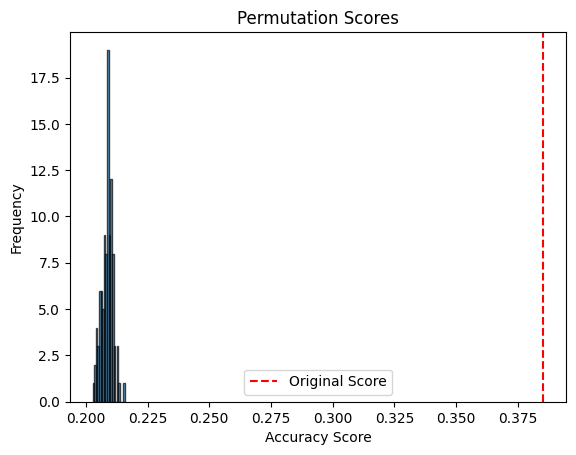

In [88]:
# Plot permutation test scores
plt.hist(permutation_scores, bins=20, edgecolor='k', alpha=0.7)
plt.axvline(score, color='r', linestyle='--', label='Original Score')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Scores')
plt.legend()
plt.show()

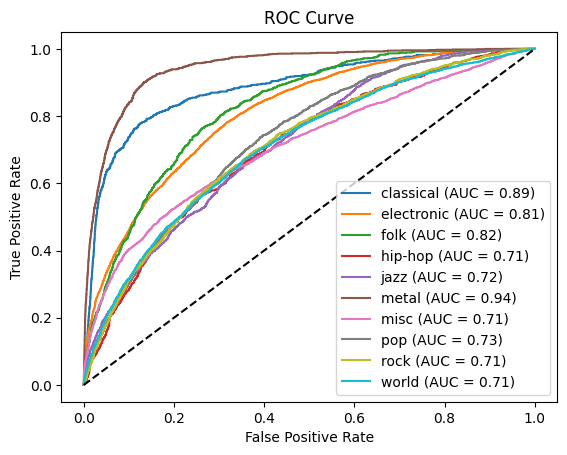

In [102]:
# ROC and AUC
for i, genre in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(Y_test == i, Y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{genre} (AUC = {auc_score:.2f})")

# axes
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

## KNN/Decision Trees/Random Forest

Since one of our main goals with the project was to see if we can classify or predict genres, KNN, decision trees, and random forests were good models for exploring this question. We decided to start by building a simple decision tree, using a grid search to tune the hyperparameters.

Decision trees are a good model for the data, since it is likely that a classification is not a simple function in any of the features, and cases overlap heavily. 

In [35]:
response_variable = "track_genre"
Y_train = grouped_spotify_train[response_variable]
Y_test = grouped_spotify_test[response_variable]

X_train = grouped_spotify_train.drop(columns=[response_variable, *string_columns])
X_test = grouped_spotify_test.drop(columns=[response_variable, *string_columns])

In [ ]:
# tuning decision tree hyperparameters
dt_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_classifier = DecisionTreeClassifier(
    max_depth=50,
    random_state=42
)

grid_search = GridSearchCV(
    dt_classifier,
    param_grid=dt_parameters,
    cv=5,
    n_jobs=3,
    verbose=2
)

grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=50, random_state=42),
             n_jobs=3,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [64]:
dt_classifier = grid_search.best_estimator_

# predictions for testing
Y_pred = dt_classifier.predict(X_test)

# Evaluation metrics
dt_class_report = classification_report(Y_test, Y_pred, zero_division=1)
dt_conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f'Classification Report: \n {dt_class_report}')
print(f'Confusion Matrix: \n {dt_conf_matrix}')

Classification Report: 
               precision    recall  f1-score   support

   classical       0.58      0.34      0.43       607
  electronic       0.49      0.62      0.55      4026
        folk       0.37      0.27      0.31      1218
     hip-hop       0.35      0.09      0.14       578
        jazz       0.38      0.27      0.32       830
       metal       0.63      0.54      0.58      1203
        misc       0.48      0.53      0.51      5931
         pop       0.38      0.25      0.30      1825
        rock       0.38      0.25      0.30      2227
       world       0.44      0.56      0.49      4321

    accuracy                           0.46     22766
   macro avg       0.45      0.37      0.39     22766
weighted avg       0.46      0.46      0.45     22766

Confusion Matrix: 
 [[ 206   26   13    0   18    0  208   29   24   83]
 [   2 2506   71   46   32   69  655  114  109  422]
 [   2  114  327   10   71    0  267   71   76  280]
 [   0  156    8   52   10   11  105 

Our decision tree seems to have about 46% accuracy, meaning it classified about 46% of the data correctly. This is better than chance, but could still be improved. In particular, it seems our decision tree was best at calculating electronic tracks, with a precision of 62%, while it was very bad at classifying hip-hop tracks, with a precision score of only 9%.

Based on the confusion matrix, it seems like electronic tracks, when misclassified, tended to be mislabeled as pop (276 instances) or rock (265 instances), which may be some indicator towards the similarities or overlaps with these genres. We also noticed that hip-hop tends to be mislabelled as electronic, as with hip-hop tracks only 160 were correctly labelled while 283 were labelled as electronic. 

However, it is important to note that when we combined the genres into 10 more generalized genres, we caused an imbalance in samples. For example, electronic tracks have several more samples than hip-hop ones (20000 vs 3000) which may influence our decision tree's balance.

To learn more about which features in particular were contributing to our classification, we looked at the feature importances of our decision tree.

In [66]:
# Get feature importances
feature_importances = dt_classifier.feature_importances_
for i, importance in enumerate(feature_importances):
    print(f'{X_train.columns[i]}: {importance}')

popularity: 0.2200472160153845
duration_ms: 0.0852801213153109
explicit: 0.006176993344808496
danceability: 0.11891001330395011
energy: 0.04639268264190049
key: 0.0010495388111708972
loudness: 0.04128858458997459
mode: 0.006500681736710005
speechiness: 0.06524558872054981
acousticness: 0.18262725408120783
instrumentalness: 0.09890842233853107
liveness: 0.014775753707866195
valence: 0.05226490886822944
tempo: 0.05978402867389046
time_signature: 0.000748211850515286


In [68]:
# permutation importance
perm_importance = permutation_importance(
    dt_classifier,
    X_test,
    Y_test,
    n_repeats=20,
    random_state=42
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

perm_importance_df

Feature  Importance Mean  Importance Std
0         popularity         0.153321        0.002175
1        duration_ms         0.038263        0.001421
2           explicit         0.002715        0.000277
3       danceability         0.070403        0.001225
4             energy         0.026368        0.001298
5                key         0.000020        0.000083
6           loudness         0.021769        0.001009
7               mode         0.002462        0.000285
8        speechiness         0.024363        0.000918
9       acousticness         0.119643        0.002600
10  instrumentalness         0.058062        0.001181
11          liveness         0.004871        0.000420
12           valence         0.028775        0.001081
13             tempo         0.024633        0.000823
14    time_signature         0.000198        0.000110

Out of this, it seems like acousticness, popularity, and danceability have the highest importance when it comes to our decision tree. On the other hand, some of the time signatures, keys, and modes didn't really seem to be as key in feature importance.

To add more complexity to our model in hopes of improving its accuracy, we decided to try to train a random forest model on our data as well. We used a grid search again, but this time, we reduced the number of features in the search due to the higher complexity of the model requiring much longer time to do tuning.

In [38]:
rf_parameters = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
}

# Random forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
)

grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=rf_parameters,
    cv=5,
    n_jobs=1,
    verbose=2
)
grid_search.fit(X_train, Y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.6s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.4s
[CV] END .....................max_depth=20, n_estimators=100; total time=  10.8s
[CV] END .....................max_depth=20, n_est

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=20, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [10, 20, 30], 'n_estimators': [100, 200]},
             verbose=2)

In [41]:
print(grid_search.best_params_)
rf_classifier = grid_search.best_estimator_
Y_pred_rf = rf_classifier.predict(X_test)

{'max_depth': 20, 'n_estimators': 200}


In [46]:
# Evaluation metrics
rf_train_accuracy = accuracy_score(Y_train, rf_classifier.predict(X_train))
rf_accuracy = accuracy_score(Y_test, Y_pred_rf)
rf_class_report = classification_report(Y_test, Y_pred_rf, zero_division=1)
rf_conf_matrix = confusion_matrix(Y_test, Y_pred_rf)

print(f'Train accuracy: {rf_train_accuracy}')
print(f'Accuracy: {rf_accuracy}')
print(f'Classification Report: \n {rf_class_report}')
print(f'Confusion Matrix:')
rf_conf_matrix

Train accuracy: 0.9188239428370621
Accuracy: 0.5578054994289731
Classification Report: 
               precision    recall  f1-score   support

   classical       0.60      0.36      0.45       607
  electronic       0.66      0.70      0.68      4026
        folk       0.68      0.55      0.61      1218
     hip-hop       0.30      0.08      0.12       578
        jazz       0.60      0.35      0.45       830
       metal       0.65      0.62      0.63      1203
        misc       0.50      0.65      0.57      5931
         pop       0.48      0.34      0.40      1825
        rock       0.48      0.33      0.39      2227
       world       0.55      0.62      0.59      4321

    accuracy                           0.56     22766
   macro avg       0.55      0.46      0.49     22766
weighted avg       0.55      0.56      0.55     22766

Confusion Matrix:


array([[ 219,   11,   10,    0,    5,    4,  249,   18,   14,   77],
       [   6, 2802,   12,   13,   27,   43,  677,   83,   63,  300],
       [   1,   34,  672,    6,   10,    1,  224,   55,   48,  167],
       [   0,  158,    7,   45,    9,    5,   96,   51,   39,  168],
       [   2,   66,   21,    6,  294,    2,  147,   48,   73,  171],
       [   1,   46,    3,    0,    3,  746,  267,    8,  109,   20],
       [  84,  522,   74,    1,   40,  178, 3884,  195,  282,  671],
       [   1,  200,   49,   31,   26,   27,  515,  613,   78,  285],
       [  16,  119,   68,   16,   36,  119,  751,   59,  746,  297],
       [  32,  286,   79,   30,   36,   28,  901,  136,  115, 2678]])

Our random forest model does seem to do much better than just one decision tree, with an increase of accuracy from ~45% to ~56%. Additionally, the individual genres' precisions for the most part seemed to get better. This time, classical and metal genres had the highest precision, which, when thinking back to our EDA where the two variables seemed to stand out, makes sense. Similar with decision trees, the model was not as good at classifying hip-hop tracks.

Looking again at feature importance for our random forest:

In [ ]:
# permutation importance
perm_importance_rf = permutation_importance(
    rf_classifier,
    X_test,
    Y_test,
    n_repeats=20,
    random_state=42,
)

In [44]:
perm_importance_rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': perm_importance_rf.importances_mean,
    'Importance Std': perm_importance_rf.importances_std
})

perm_importance_rf_df

Feature  Importance Mean  Importance Std
0         popularity         0.119450        0.002112
1        duration_ms         0.034292        0.001582
2           explicit         0.002846        0.000426
3       danceability         0.053180        0.001849
4             energy         0.030636        0.001262
5                key        -0.000356        0.000504
6           loudness         0.016490        0.001054
7               mode         0.004507        0.000626
8        speechiness         0.027034        0.001284
9       acousticness         0.079966        0.001813
10  instrumentalness         0.055049        0.001748
11          liveness         0.004076        0.000793
12           valence         0.031598        0.001160
13             tempo         0.014998        0.001157
14    time_signature         0.000283        0.000386

With our random forest, the importance of specific variables changed slightly from our decision tree, but the most important features, popularity, danceability, and acousticness, stayed about the same.

We also looked into training a KNN model for classification as well, to see how it may do against our decision tree and random forest.

In [132]:
# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, Y_train)

# Make predictions
Y_pred_knn = knn_classifier.predict(X_test)

# Evaluate
knn_accuracy = accuracy_score(Y_test, Y_pred_knn)
knn_class_report = classification_report(Y_test, Y_pred_knn, zero_division=1)
knn_conf_matrix = confusion_matrix(Y_test, Y_pred_knn)

print(f'Accuracy: {knn_accuracy}')
print(f'Classification Report: {knn_class_report}')
print(f'Confusion Matrix:')
knn_conf_matrix

Accuracy: 0.29438636563296144
Classification Report:               precision    recall  f1-score   support

   classical       0.09      0.10      0.10       607
  electronic       0.31      0.47      0.37      4026
        folk       0.25      0.24      0.25      1218
     hip-hop       0.11      0.06      0.08       578
        jazz       0.41      0.29      0.34       830
       metal       0.13      0.08      0.10      1203
        misc       0.32      0.39      0.35      5931
         pop       0.19      0.11      0.14      1825
        rock       0.27      0.17      0.21      2227
       world       0.33      0.28      0.31      4321

    accuracy                           0.29     22766
   macro avg       0.24      0.22      0.22     22766
weighted avg       0.28      0.29      0.28     22766

Confusion Matrix:


array([[  59,  143,   29,    9,    6,   26,  221,   14,   24,   76],
       [  79, 1875,  119,   47,   48,   84,  973,  160,  150,  491],
       [  33,  252,  290,   21,   26,   32,  338,   33,   45,  148],
       [  11,  150,   24,   35,   17,   21,  162,   34,   31,   93],
       [  13,  159,   26,   14,  242,   18,  164,   44,   52,   98],
       [  41,  268,   44,   22,   16,   95,  416,   46,   87,  168],
       [ 178, 1431,  238,   62,   95,  213, 2309,  248,  346,  811],
       [  50,  421,   96,   28,   35,   59,  578,  193,   98,  267],
       [  56,  440,  107,   23,   59,   84,  715,   87,  386,  270],
       [ 104, 1004,  173,   53,   43,  115, 1274,  139,  198, 1218]])

Unfortunately, our KNN model seems to be a lot worse than both our decision tree and random forest, with an accuracy of only ~29%. Classical, hip-hop, and metal do the worst on this, likely because of the class (genre) imbalance we have from our groupings. KNN doesn't seem to be a very good model for our data.

## PCA/Clustering

We tried to conduct PCA and clustering on our data to see if dimensionality reduction or investigation into underlying structures like clusters may relate or help us investigate genre. We tried dimensionality reduction with PCA first.

In [155]:
# data pre-processing
response_variable = 'track_genre'
categorical_columns = [x for x in categorical_columns if x != response_variable]

# drop string columns and response variable
X_train = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
Y_train = grouped_spotify_train[response_variable]

Explained variance ratio for each component: 
 [0.10836837 0.09131586 0.06138773 0.05869306 0.04588949 0.0434164
 0.0361926  0.03418232 0.03292623 0.03291811] 

Cumulative explained variance: 
 [0.10836837 0.19968423 0.26107196 0.31976503 0.36565451 0.40907091
 0.44526351 0.47944583 0.51237206 0.54529017]


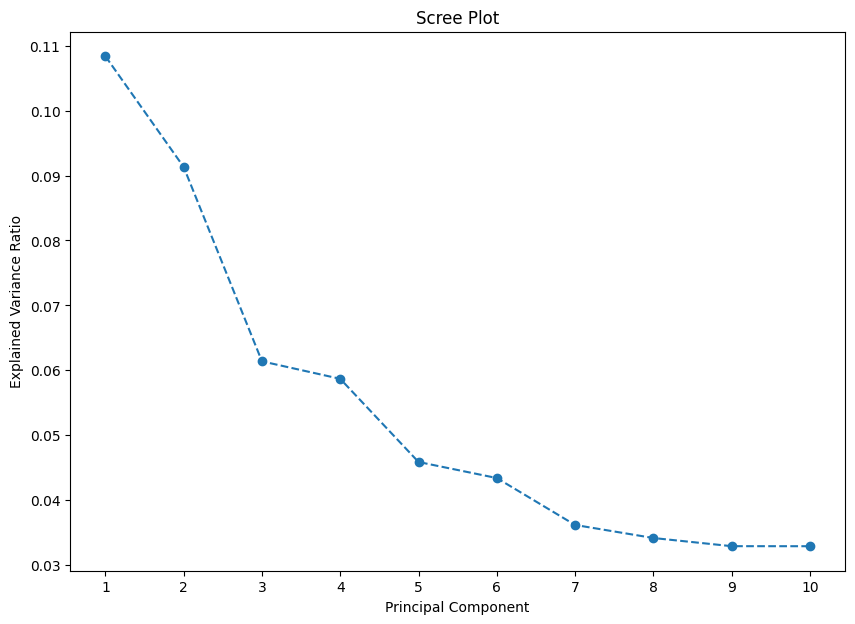

In [156]:
# do PCA on X
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(n_components)])

explained_variance = pca.explained_variance_ratio_

# Check explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio for each component: \n {explained_variance} \n")
print(f"Cumulative explained variance: \n {np.cumsum(explained_variance)}")

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

Based on the Scree Plot, it seems like taking the first 3 or 4 principal components would be best for still covering a good amount of variance (~0.18 cumulative) and also keeping it simple for easier visualizations. We plotted the first two PCs and colored them by genre to see if there were any interesting relationships.

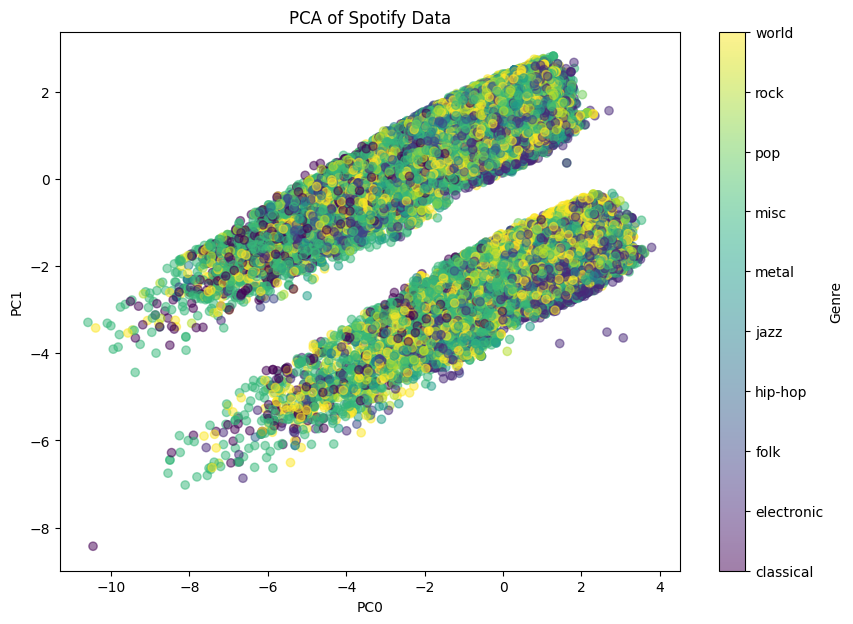

In [157]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_train)

# plot the first two principal components
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_df['PC0'],
    X_pca_df['PC1'],
    c=Y_encoded,
    cmap='viridis',
    alpha=0.5
)
# label by Y_encoded
cbar = plt.colorbar(scatter)
cbar.set_label('Genre')
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PCA of Spotify Data')
plt.show()


The points do seem like they're getting clustered and colored in some way on the PCA graph which is interesting, but it also looks like there are a lot of overlapping dots, so we may be losing some important dimensions. 

We decided to do a regression on the PCA transformed data to see if the PCA improved the fit at all.

Accuracy: 0.3139769832205921


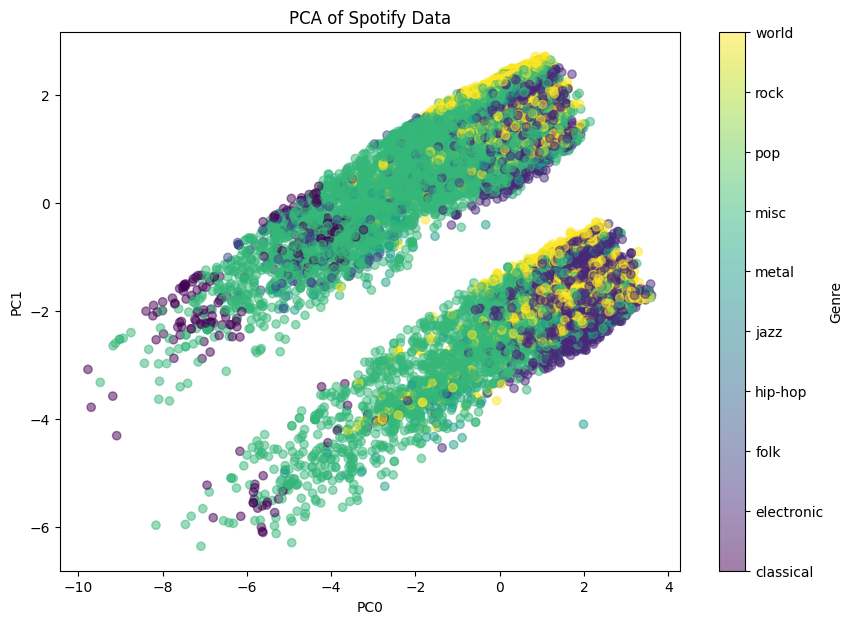

In [159]:
# do a regression using PCA transformed data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_test = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_test)
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=[f'PC{i}' for i in range(n_components)])
Y_test = grouped_spotify_test[response_variable]

model = LogisticRegression(max_iter=1000)
model.fit(X_pca_df, Y_train)
Y_pred = model.predict(X_test)
Y_pred_encoded = label_encoder.transform(Y_pred)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

# plot it
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_test['PC0'],
    X_test['PC1'],
    c=Y_pred_encoded,
    cmap='viridis',
    alpha=0.5
)
# label by Y_encoded
cbar = plt.colorbar(scatter)
cbar.set_label('Genre')
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PCA of Spotify Data')
plt.show()

Though the accuracy isn't very high with our logistic regression fit, the graph reminded us of what Gaussian Mixture Models tend to look like, so we attempted applying a GMM to the PCA transformed data as well.

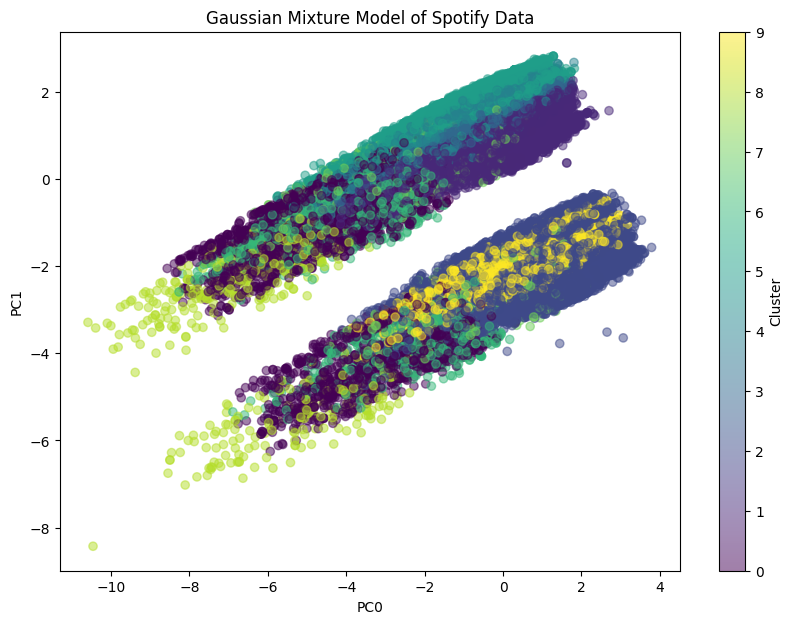

In [161]:
# gaussian mixture model
n_components = 10
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_pca_df)
Y_pred = gmm.predict(X_pca_df)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_df['PC0'],
    X_pca_df['PC1'],
    c=Y_pred,
    cmap='viridis',
    alpha=0.5
)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
cbar.set_ticks(range(n_components))
cbar.set_ticklabels(range(n_components))

plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Gaussian Mixture Model of Spotify Data')
plt.show()


In [162]:
# evaluate the model
sil_score = silhouette_score(X_pca_df, Y_pred)
print(sil_score)

0.18532988287647995


While the GMM has a pretty nice graph that almost looks right, the silhouette score is not good at all. We decided to try it again with just two genres, pop and not pop (other) to see if it might improve the score.

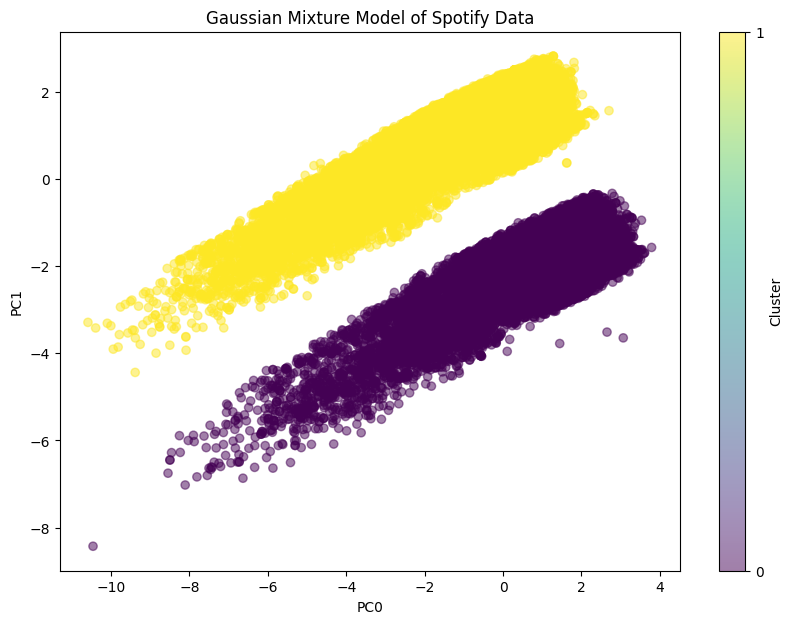

In [163]:
# Trying the data but with 2 classes: pop and other
Y_binary = Y_train.apply(lambda x: 'pop' if x == 'pop' else 'misc')

# do GMM
n_components = 2
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_pca_df)
Y_pred = gmm.predict(X_pca_df)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_df['PC0'],
    X_pca_df['PC1'],
    c=Y_pred,
    cmap='viridis',
    alpha=0.5
)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
cbar.set_ticks(range(n_components))
cbar.set_ticklabels(range(n_components))

plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Gaussian Mixture Model of Spotify Data')
plt.show()


In [164]:
# Evaluate
Y_binary_encoded = label_encoder.transform(Y_binary).reshape(-1, 1)
sil_score = silhouette_score(Y_binary_encoded, Y_pred)

print(sil_score)

-0.030537843090037743


Unfortunately, our silhouette score is still less than zero, indicating that our clustering with the GMM is not very good. We decided to try other methods of clustering, K-means and agglomerative, as well to see if they would be better.

Note that when working with the original data that has 114 genres, it's very evenly distributed (1000 samples per genre). This may imply that the sampling was not random, and was stratified via the genre subpopulations. This is likely not proportional to the actual song population, which may lead to bias since underrepresented genres are now equally represented with overrepresented genres. Since we have no way to recover original proportions without using external data, we will simply have to be weary of the results.

Our goal with clustering is to be able to see if it might be able to help us in classifying or predicting the genre of the song. We first start to see if there is any obvious clustering using both agglomerative (hierarchial) and k-means clustering.

In [175]:
X_train = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_train)
X_test = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_test)

scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

Y_train = grouped_spotify_train[response_variable]
Y_test = grouped_spotify_test[response_variable]

In [172]:
# sample the training set to speed up hierarchical clustering
sample_size = 0.3
hierarchical_sample_split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=1 - sample_size,
    random_state=42
)
gmm_sample_size = 0.8

for train_index, _ in hierarchical_sample_split.split(X_train, Y_train):
    X_sample = X_train.iloc[train_index].copy()
    Y_sample = Y_train.iloc[train_index].copy()

In [173]:
n_clusters = 10

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=0
)
hierarchical = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
gmm = GaussianMixture(
    n_components=n_clusters,
    random_state=0
)

hierarchical.fit(X_sample)
kmeans.fit(X_sample)
gmm.fit(X_train)

GaussianMixture(n_components=10, random_state=0)

In [176]:
X_sample["hcluster"] = hierarchical.labels_
X_sample["kcluster"] = kmeans.labels_
Y_pred_gmm = gmm.predict(X_test)

# encode Y_test_gmm labels using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
Y_train_encoded = label_encoder.transform(Y_train)

In [ ]:
# Analyze
hclust_kclust_ari = adjusted_rand_score(X_sample["hcluster"], X_sample["kcluster"])

hclust_y_ari = adjusted_rand_score(X_sample["hcluster"], Y_sample)
kclust_y_ari = adjusted_rand_score(X_sample["kcluster"], Y_sample)
kclust_y_ari = adjusted_rand_score(Y_test, Y_pred_gmm)

hclust_silhouette = silhouette_score(X_sample, X_sample["hcluster"])
kclust_silhouette = silhouette_score(X_sample, X_sample["kcluster"])
gmm_silhouette = silhouette_score(X_test, Y_pred_gmm)

print(f'''
Hierarchical clustering vs KMeans clustering ARI: {hclust_kclust_ari}

Hierarchical clustering vs true labels ARI: {hclust_y_ari}
KMeans clustering vs true labels ARI: {kclust_y_ari}
GMM clustering vs true labels ARI: {kclust_y_ari}

Hierarchical clustering silhouette score: {hclust_silhouette}
KMeans clustering silhouette score: {kclust_silhouette}
GMM clustering silhouette score: {gmm_silhouette}
''')


Hierarchical clustering vs KMeans clustering ARI: 0.4500737924478871

Hierarchical clustering vs true labels ARI: 0.0019950842701675522
KMeans clustering vs true labels ARI: 0.0022420916160579103
GMM clustering vs true labels ARI: 0.0022420916160579103

Hierarchical clustering silhouette score: 0.16310140621490865
KMeans clustering silhouette score: 0.22201717965090853
GMM clustering silhouette score: 0.1694012135651898



In [180]:
pd.set_option('display.max_columns', None)
X_sample.groupby("hcluster").count()

key_0  key_1  key_2  key_3  key_4  key_5  key_6  key_7  key_8  \
hcluster                                                                  
0          4098   4098   4098   4098   4098   4098   4098   4098   4098   
1          4902   4902   4902   4902   4902   4902   4902   4902   4902   
2          4188   4188   4188   4188   4188   4188   4188   4188   4188   
3          1190   1190   1190   1190   1190   1190   1190   1190   1190   
4          1983   1983   1983   1983   1983   1983   1983   1983   1983   
5          1515   1515   1515   1515   1515   1515   1515   1515   1515   
6          1497   1497   1497   1497   1497   1497   1497   1497   1497   
7           334    334    334    334    334    334    334    334    334   
8           614    614    614    614    614    614    614    614    614   
9           167    167    167    167    167    167    167    167    167   

          key_9  key_10  key_11  mode_0  mode_1  time_signature_0  \
hcluster                                                            
0          4098    4098    4098    4098    4098              4098   
1          4902    4902    4902    4902    4902              4902   
2          4188    4188    4188    4188    4188              4188   
3          1190    1190    1190    1190    1190              1190   
4          1983    1983    1983    1983    1983              1983   
5          1515    1515    1515    1515    1515              1515   
6          1497    1497    1497    1497    1497              1497   
7           334     334     334     334     334               334   
8           614     614     614     614     614               614   
9           167     167     167     167     167               167   

          time_signature_1  time_signature_3  time_signature_4  \
hcluster                                                         
0                     4098              4098              4098   
1                     4902              4902              4902   
2                     4188              4188              4188   
3                     1190              1190              1190   
4                     1983              1983              1983   
5                     1515              1515              1515   
6                     1497              1497              1497   
7                      334               334               334   
8                      614               614               614   
9                      167               167               167   

          time_signature_5  popularity  duration_ms  explicit  danceability  \
hcluster                                                                      
0                     4098        4098         4098      4098          4098   
1                     4902        4902         4902      4902          4902   
2                     4188        4188         4188      4188          4188   
3                     1190        1190         1190      1190          1190   
4                     1983        1983         1983      1983          1983   
5                     1515        1515         1515      1515          1515   
6                     1497        1497         1497      1497          1497   
7                      334         334          334       334           334   
8                      614         614          614       614           614   
9                      167         167          167       167           167   

          energy   key  loudness  mode  speechiness  acousticness  \
hcluster                                                            
0           4098  4098      4098  4098         4098          4098   
1           4902  4902      4902  4902         4902          4902   
2           4188  4188      4188  4188         4188          4188   
3           1190  1190      1190  1190         1190          1190   
4           1983  1983      1983  1983         1983          1983   
5           1515  1515      1515  1515         1515    

Based on our investigations, the K-means and Agglomerative clustering did ok, with silhouette scores for both methods being ~0.5. However, like before, GMM did terribly. However, the adjusted rand index when compared with track genre was negligible, meaning that the clusters formed do not at all correspond to genre, so clustering will probably not help us with our classification problem.

## Neural Networks

We then applied neural networks to see if they could approximate the genre as a function of the other features.

We first put one-hot-encoded the data, scaled it, and put it onto the GPU (if available). We used a batch size of 64 for data loading.

In [185]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [186]:
response_variable = "track_genre"

# remove string columns and one-hot encode
Y_train = grouped_spotify_train[response_variable]
Y_val = grouped_spotify_val[response_variable]

X_train = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_train)
X_val = ohe_grouped_column_transformer_wo_genre.transform(grouped_spotify_val)

label_encoder = LabelEncoder()
label_encoder.fit(grouped_spotify[response_variable])
Y_train = label_encoder.transform(Y_train)
Y_val = label_encoder.transform(Y_val)

# create class weights
Y_train_unique = np.unique(Y_train, return_counts=True)
class_weights = len(Y_train) / (Y_train_unique[1] * len(Y_train_unique[1]))
for i, w in enumerate(class_weights):
    label_encoded = Y_train_unique[0][i]
    label_decoded = label_encoder.inverse_transform([label_encoded])[0]
    w_str = f"{w:.3f}"
    count_str = f"{Y_train_unique[1][i]:,}"
    print(f"{label_decoded + ':': <16}{w_str: <16}{count_str}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long).to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# create dataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# create dataloaders
batch_size = 64
num_workers = 12 if is_linux else 0
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

classical:      3.820           1,788
electronic:     0.569           12,002
folk:           1.895           3,604
hip-hop:        3.744           1,824
jazz:           2.854           2,393
metal:          1.876           3,640
misc:           0.380           17,962
pop:            1.268           5,386
rock:           1.040           6,569
world:          0.520           13,128


Then we defined our model. Via trial and error, we found that using ReLU caused slow training (since the gradient is 0 if the value is negative), and including dropout added to much variation to the training loss. In addition, switching from softmax to log softmax helped the early stopping algorithm from stopping too early. Thus, we kept a simple model, with 2 fully connected hidden layers, with sigmoid activation for the hidden layers and log softmax for the output.

We used the Adam optimizer with weigth decay for regularization using cross entropy loss. We also used a learning rate scheduler which reduced learning rate by 90% every 10 epochs.

In [187]:
# Create model
class SpotifyModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        lr: float = 0.01,
        class_weights: torch.tensor = None,
        hidden_dim1: int = 64,
        hidden_dim2: int = 64,
        weight_decay: float = 0.01,
    ):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Sigmoid(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Sigmoid(),
            nn.Linear(hidden_dim2, output_dim),
            nn.LogSoftmax(dim=1),
        )
        self.n_classes = output_dim
        self.weight_decay = weight_decay
        self.epoch_metrics = []
        self.train_metrics_stack = []
        self.validation_metrics_stack = []
        self.loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        self.train_metrics_stack.append({
            'train_loss': loss,
        })
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.validation_metrics_stack.append({
            'val_loss': loss,
            'val_acc': acc
        })
        self.log("val_loss", loss)
        return loss

    def on_validation_epoch_end(self):
        # sum in validation stack
        if len(self.validation_metrics_stack) == 0:
            return
        if len(self.train_metrics_stack) == 0:
            return
        val_loss = torch.stack([x['val_loss'] for x in self.validation_metrics_stack]).mean()
        val_acc = torch.stack([x['val_acc'] for x in self.validation_metrics_stack]).mean()
        train_loss = torch.stack([x['train_loss'] for x in self.train_metrics_stack]).mean()
        self.epoch_metrics.append({
            'val_loss': val_loss.cpu(),
            'val_acc': val_acc.cpu(),
            'train_loss': train_loss.cpu(),
        })
        # clear stack
        self.validation_metrics_stack = []
        self.train_metrics_stack = []


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


To pick an initial learning rate, we used PyTorch's `lr_find` function, which gave us an initial learning rate of about 0.002. We then trained the model, which stopped early at 27 epochs. 

In [ ]:
input_dim = X_train.shape[1]
output_dim = len(
    label_encoder.classes_
)
lr = 0.001

model = SpotifyModel(
    input_dim,
    output_dim,
    lr=lr,
    class_weights=class_weights_tensor
).to(device)

# train model
early_stopping = pl_callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min'
)

use_checkpoint = False
ckpt_path="epoch=12-step=18499.ckpt" if use_checkpoint else None
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        early_stopping
    ]
)

# tune the model
from lightning.pytorch.tuner.tuning import Tuner
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=validation_loader,
    min_lr=1e-10,
    max_lr=1e-1,
    num_training=100,
)

model.lr = lr_finder.suggestion()
print(f"Learning rate: {model.lr}")

trainer.fit(
    model,
    train_loader,
    validation_loader,
    ckpt_path=ckpt_path
)

/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 132.55it/s]
Learning rate set to 0.0019498445997580478
Restoring states from the checkpoint path at /home/ketexon/programming/csm148-spotiflies/.lr_find_71f92498-ffbf-4528-aab4-a052b2bdc14c.ckpt
Restored all states from the checkpoint at /home/ketexon/programming/csm148-spotiflies/.lr_find_71f92498-ffbf-4528-aab4-a052b2bdc14c.ckpt

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Sequential       | 6.7 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K   

Learning rate: 0.0019498445997580478
Epoch 27: 100%|██████████| 1423/1423 [00:14<00:00, 100.88it/s, v_num=55]    


We then plotted a classification report on the model.

In [ ]:
# evaluate model
model.eval()
with torch.no_grad():
    outputs = model.to(device)(X_val_tensor.to(device)).cpu()
    _, predicted = torch.max(outputs.data, 1)
    value_counts = pd.DataFrame(predicted).value_counts()
    for label in label_encoder.classes_:
        class_encoded = label_encoder.transform([label])[0]
        count = value_counts.get(class_encoded, 0)
        print(f"{label}: {count}")
    class_report = classification_report(
        Y_val,
        predicted,
        labels=range(len(label_encoder.classes_)),
        target_names=label_encoder.classes_,
        zero_division=1
    )
model.train()

print(class_report)

classical: 4629
electronic: 4627
folk: 2029
hip-hop: 0
jazz: 890
metal: 6415
misc: 3462
pop: 0
rock: 609
world: 105
              precision    recall  f1-score   support

   classical       0.10      0.77      0.18       607
  electronic       0.26      0.30      0.28      4026
        folk       0.09      0.15      0.11      1218
     hip-hop       1.00      0.00      0.00       578
        jazz       0.07      0.07      0.07       830
       metal       0.17      0.90      0.28      1203
        misc       0.25      0.15      0.19      5931
         pop       1.00      0.00      0.00      1825
        rock       0.09      0.03      0.04      2227
       world       0.30      0.01      0.01      4321

    accuracy                           0.17     22766
   macro avg       0.33      0.24      0.12     22766
weighted avg       0.30      0.17      0.13     22766



The classification shows pretty bad results, with overall 17% accuracy (which is hardly better than uniform, at 10%).

However, something interesting of note is that the recall for classical and metal was significantly high. This means that if the model predicted that a song was metal or classical, it was likely correct. Something else of note was that pop and hip hop, the most and least represented classes, had 0 predictions. This was stranger, but through othe models, we saw that the class imbalance disproportionately made more represented classes be predicted. When we added class weights, this might have overcompensated for pop, leading to pop having poor predictions, and undercompensated for hip-hop.

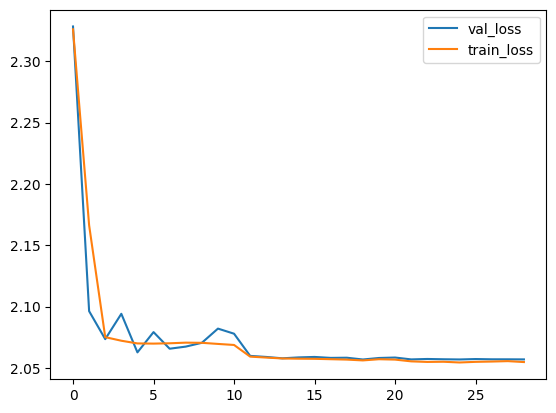

In [ ]:
# Graph epoch metrics
import matplotlib.pyplot as plt

# plot epoch to val loss and train loss
plt.plot([x['val_loss'].cpu() for x in model.epoch_metrics], label='val_loss')
plt.plot([x['train_loss'].cpu() for x in model.epoch_metrics], label='train_loss')
plt.legend()
plt.show()


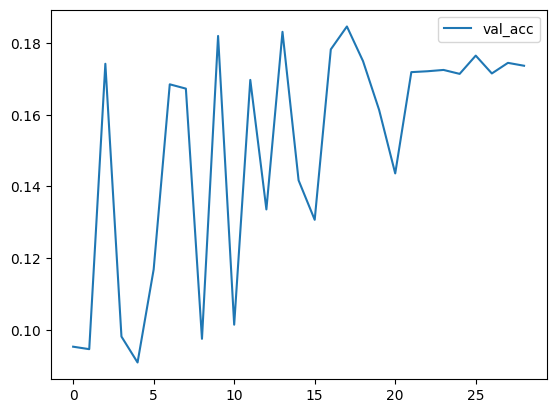

In [ ]:
# plot accuracy per epoch
plt.plot([x['val_acc'].cpu() for x in model.epoch_metrics], label='val_acc')
plt.legend()
plt.show()

Plotting the validation and training loss, as well as the model accuracy over epochs, we can see that thte loss did shrink over time, with accuracy never really increasing. This could be an indicator that cross entropy was not a good loss function.